In [52]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import geopandas as gpd
import warnings
warnings. filterwarnings('ignore')

# Загрузка данных о дорогах и домах
roads = gpd.read_file('RU-CITY-001-f83bbaf9-20240705-ru-gpkg 3/data/highway-line.gpkg')
buildings = gpd.read_file('RU-CITY-001-f83bbaf9-20240705-ru-gpkg 3/data/building-polygon.gpkg')
crossroads = gpd.read_file('RU-CITY-001-f83bbaf9-20240705-ru-gpkg 3/data/highway-crossing-point.gpkg')

In [2]:
population_df = pd.read_csv('population.csv')
density_df = pd.read_csv('density.csv')

In [3]:
density_df = density_df.rename(columns={
    'Column_1': 'district',
    'Column_2': 'count_density'
})
population_df = population_df.rename(columns={
    'Column_0': 'year',
    'Column_1': 'district',
    'Column_2': 'count_population'
})
population_df = population_df[population_df['year'] == 2017]
density_df = density_df.drop(columns=['Column_0'])

In [4]:
population_df

,year,district,count_population
730,2017,Академический,109200.0
731,2017,Алексеевский,80400.0
732,2017,Алтуфьевский,57300.0
733,2017,Арбат,35000.0
734,2017,Аэропорт,79100.0
...,...,...,...
871,2017,Южное Тушино,108600.0
872,2017,Южнопортовый,74200.0
873,2017,Якиманка,27500.0
874,2017,Ярославский,97500.0


In [5]:
# Объединение данных по названию района
# Предполагается, что названия районов совпадают
combined_df = pd.merge(population_df, density_df, on='district', how='inner')

In [6]:
# Просмотр объединённого DataFrame
combined_df.head()

,year,district,count_population,count_density
0,2017,Академический,109200.0,18736.02
1,2017,Алексеевский,80400.0,15196.79
2,2017,Алтуфьевский,57300.0,17664.00
3,2017,Арбат,35000.0,16838.39
4,2017,Аэропорт,79100.0,17313.10


In [7]:
combined_df = combined_df.drop(columns=['year'])

In [8]:
# Проверка данных
roads.head()

,NAME,NAME_EN,NAME_RU,REF,HIGHWAY,ONEWAY,BRIDGE,TUNNEL,MAXSPEED,LANES,WIDTH,SURFACE,OSM_TYPE,OSM_ID,geometry
0,Барвихинская улица,Barvikhinskaya steet,Барвихинская улица,None,tertiary,yes,None,None,None,2,None,asphalt,way,4870954,"LINESTRING (37.39966 55.71582, 37.39924 55.715..."
1,Барвихинская улица,Barvikhinskaya steet,Барвихинская улица,None,tertiary,None,None,None,None,2,None,asphalt,way,4870985,"LINESTRING (37.39855 55.71576, 37.39722 55.715..."
2,улица Толбухина,None,улица Толбухина,None,tertiary,yes,None,None,None,1,None,asphalt,way,4871028,"LINESTRING (37.39910 55.72405, 37.39921 55.724..."
3,проезд Толбухина,Tolbukhina proezd,проезд Толбухина,None,residential,None,None,None,None,2,None,asphalt,way,4871099,"LINESTRING (37.39703 55.71755, 37.39752 55.717..."
4,None,None,None,52B,secondary_link,yes,None,None,None,1,None,asphalt,way,4871185,"LINESTRING (37.40050 55.70100, 37.40038 55.701..."


### Алгоритм

In [5]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString, box, Point
import warnings
from tqdm import tqdm
import os

warnings.filterwarnings('ignore')


def create_square_polygon(center_x, center_y, size=200):
    meter_in_degree = 1 / 111000
    half_size_deg = (size / 2) * meter_in_degree
    minx = center_x - half_size_deg
    miny = center_y - half_size_deg
    maxx = center_x + half_size_deg
    maxy = center_y + half_size_deg
    polygon = box(minx, miny, maxx, maxy)
    return polygon


def add_new_paths_to_cut_nodes(G, cut_edges):
    for u, v in cut_edges:
        if G.has_node(u) and G.has_node(v) and not G.has_edge(u, v):
            point_u = G.nodes[u]['geometry']
            point_v = G.nodes[v]['geometry']
            new_line = LineString([point_u, point_v])
            G.add_edge(u, v, key=0, geometry=new_line, length=new_line.length)
    return G


def add_parallel_line(G, u, v, line, offset=20 / 111000):
    try:
        parallel_line = line.parallel_offset(offset, side='left', join_style=2)
        G.add_edge(u, v, key='parallel', geometry=parallel_line, length=parallel_line.length)
    except Exception as e:
        print(f"Ошибка при создании параллельной линии для узлов {u} и {v}: {e}")


def ensure_coordinates(G):
    nodes_to_remove = []
    for node_id, data in G.nodes(data=True):
        if 'x' not in data or 'y' not in data:
            if 'geometry' in data and isinstance(data['geometry'], Point):
                G.nodes[node_id]['x'] = data['geometry'].x
                G.nodes[node_id]['y'] = data['geometry'].y
            else:
                nodes_to_remove.append(node_id)
    G.remove_nodes_from(nodes_to_remove)


def trim_line_to_boundary(line, boundary):
    if line.intersects(boundary):
        trimmed_line = line.difference(boundary)
        if isinstance(trimmed_line, LineString):
            return trimmed_line
        elif trimmed_line and isinstance(trimmed_line, (list, tuple)):
            return trimmed_line[0]
    return line


def connect_to_nearest_nodes(G, jc_polygon, nodes_gdf, offset=20 / 111000, min_connections=4):
    connections_made = 0
    added_nodes = []
    new_edges = []
    polygon_points = list(jc_polygon.exterior.coords)
    num_points = len(polygon_points)

    step = max(1, num_points // min_connections)
    used_indices = set()
    use_less_nearby = True

    for i in range(min_connections):
        if connections_made >= min_connections:
            break

        point_index = (i * step) % num_points
        if point_index in used_indices:
            continue
        used_indices.add(point_index)

        jc_point = Point(polygon_points[point_index])
        nodes_gdf['distance'] = nodes_gdf.geometry.apply(lambda p: p.distance(jc_point))

        if use_less_nearby and connections_made == min_connections - 1:
            nearest_nodes = nodes_gdf.sort_values(by='distance').iloc[[2]]
            use_less_nearby = False
        else:
            nearest_nodes = nodes_gdf.sort_values(by='distance').head(1)

        for idx, row in nearest_nodes.iterrows():
            node_id = row.name
            if node_id in G.nodes and 'x' in G.nodes[node_id] and 'y' in G.nodes[node_id]:
                node_point = Point(row['x'], row['y'])
                line_to_node = LineString([jc_point, node_point])

                new_node_id = len(G.nodes)
                G.add_node(new_node_id, x=jc_point.x, y=jc_point.y, geometry=jc_point)

                G.add_edge(new_node_id, node_id, key=0, geometry=line_to_node, length=line_to_node.length)
                new_edges.append((new_node_id, node_id, 0, G.edges[new_node_id, node_id, 0]))

                add_parallel_line(G, new_node_id, node_id, line_to_node, offset)
                new_edges.append((new_node_id, node_id, 'parallel', G.edges[new_node_id, node_id, 'parallel']))
                added_nodes.append(new_node_id)
                connections_made += 1

    if connections_made < min_connections:
        jc_point = Point(polygon_points[0])
        nodes_gdf['distance'] = nodes_gdf.geometry.apply(lambda p: p.distance(jc_point))
        additional_nearest_nodes = nodes_gdf.sort_values(by='distance').head(min_connections - connections_made)

        for idx, row in additional_nearest_nodes.iterrows():
            node_id = row.name
            if node_id in G.nodes and 'x' in G.nodes[node_id] and 'y' in G.nodes[node_id]:
                node_point = Point(row['x'], row['y'])
                line_to_node = LineString([jc_point, node_point])

                new_node_id = len(G.nodes)
                G.add_node(new_node_id, x=jc_point.x, y=jc_point.y, geometry=jc_point)

                G.add_edge(new_node_id, node_id, key=0, geometry=line_to_node, length=line_to_node.length)
                new_edges.append((new_node_id, node_id, 0, G.edges[new_node_id, node_id, 0]))

                add_parallel_line(G, new_node_id, node_id, line_to_node, offset)
                new_edges.append((new_node_id, node_id, 'parallel', G.edges[new_node_id, node_id, 'parallel']))
                added_nodes.append(new_node_id)
                connections_made += 1

    for u, v, key, data in list(G.edges(data=True, keys=True)):
        if 'geometry' in data and isinstance(data['geometry'], LineString):
            line = data['geometry']
            trimmed_line = trim_line_to_boundary(line, jc_polygon)
            if trimmed_line != line:
                G.add_edge(u, v, key=key, geometry=trimmed_line, length=trimmed_line.length)

    return G, new_edges


def add_residential_complex(G, jc_location, size=200):
    center_x, center_y = jc_location
    jc_polygon = create_square_polygon(center_x, center_y, size)
    edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)
    edges_to_remove = edges_gdf[edges_gdf.intersects(jc_polygon)].index
    cut_edges = [(u, v) for u, v, key in edges_to_remove]
    G.remove_edges_from(edges_to_remove)
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    G = add_new_paths_to_cut_nodes(G, cut_edges)
    edges_removed = list(edges_to_remove)
    return G, jc_polygon, edges_removed


class GraphManager:
    def __init__(self):
        print("Загрузка данных...")
        roads = gpd.read_file('RU-CITY-001-f83bbaf9-20240705-ru-gpkg 3/data/highway-line.gpkg')
        buildings = gpd.read_file('RU-CITY-001-f83bbaf9-20240705-ru-gpkg 3/data/building-polygon.gpkg')
        crossroads = gpd.read_file('RU-CITY-001-f83bbaf9-20240705-ru-gpkg 3/data/highway-crossing-point.gpkg')
        crossroads = crossroads.set_index('OSM_ID')
        crossroads['x'] = crossroads.geometry.x
        crossroads['y'] = crossroads.geometry.y
        print("Данные загружены.")

        roads_footway = roads[roads['HIGHWAY'] == 'footway'].copy()
        roads_footway['start_point'] = roads_footway.geometry.apply(lambda geom: Point(geom.coords[0]))
        roads_footway['end_point'] = roads_footway.geometry.apply(lambda geom: Point(geom.coords[-1]))
        all_points = pd.concat([roads_footway['start_point'], roads_footway['end_point']], ignore_index=True)
        nodes_df = pd.DataFrame({'x': [point.x for point in all_points], 'y': [point.y for point in all_points]}).drop_duplicates().reset_index(drop=True)
        nodes_df['OSM_ID'] = nodes_df.index
        nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df['x'], nodes_df['y']), crs=roads_footway.crs)

        coord_to_osmid = {(row['x'], row['y']): row['OSM_ID'] for idx, row in nodes_gdf.iterrows()}

        def get_osmid(point):
            return coord_to_osmid.get((point.x, point.y))

        roads_footway['u'] = roads_footway['start_point'].apply(get_osmid)
        roads_footway['v'] = roads_footway['end_point'].apply(get_osmid)
        edges_gdf = roads_footway[['u', 'v', 'geometry']].copy()
        edges_gdf['length'] = edges_gdf.geometry.length
        edges_gdf['key'] = edges_gdf.groupby(['u', 'v']).cumcount()
        edges_gdf = edges_gdf.set_index(['u', 'v', 'key'])
        G = ox.graph_from_gdfs(nodes_gdf, edges_gdf, graph_attrs={'crs': roads_footway.crs})

        for _, row in nodes_gdf.iterrows():
            G.nodes[row['OSM_ID']]['geometry'] = row['geometry']
            G.nodes[row['OSM_ID']]['x'] = row['x']
            G.nodes[row['OSM_ID']]['y'] = row['y']

        ensure_coordinates(G)

        self.graph_versions = {}
        self.user_inputs = []
        self.G_base = G  # Базовый граф без ЖК
        self.jc_polygons_by_year = {}  # Словарь для хранения полигонов ЖК по годам
        self.new_edges_by_year = {}    # Словарь для хранения новых ребер по годам
        self.edges_removed_by_year = {}  # Словарь для хранения удаленных ребер по годам
        self.nodes_gdf = nodes_gdf

    def add_residential_complex(self, year, location):
        print(f"Добавление ЖК для года {year} в точке {location}")
        self.user_inputs.append({'year': year, 'location': location})

        years = sorted(set([input['year'] for input in self.user_inputs]))
        print(f"Список лет с ЖК: {years}")

        # Начинаем с базового графа
        previous_G = self.G_base.copy()

        # Словари для хранения данных по годам
        jc_polygons_by_year = {}
        new_edges_by_year = {}
        edges_removed_by_year = {}

        # Обрабатываем каждый год в порядке возрастания
        for y in years:
            print(f"\nОбработка года {y}")
            G_temp = previous_G.copy()
            jc_polygons_temp = []
            new_edges_temp = []
            edges_removed_temp = []

            # Получаем все ЖК для текущего года
            complexes = [input for input in self.user_inputs if input['year'] == y]
            print(f"ЖК для года {y}: {complexes}")

            # Добавляем ЖК в граф
            for jc in complexes:
                G_temp, jc_polygon, edges_removed = add_residential_complex(G_temp, jc['location'])
                jc_polygons_temp.append(jc_polygon)
                edges_removed_temp.extend(edges_removed)

                G_temp, new_edges = connect_to_nearest_nodes(G_temp, jc_polygon, self.nodes_gdf, min_connections=4)
                new_edges_temp.extend(new_edges)

            # Сохраняем данные для текущего года
            self.graph_versions[y] = G_temp
            jc_polygons_by_year[y] = jc_polygons_temp.copy()
            new_edges_by_year[y] = new_edges_temp.copy()
            edges_removed_by_year[y] = edges_removed_temp.copy()

            # Обновляем предыдущие данные для следующей итерации
            previous_G = G_temp

        # Обновляем словари класса
        self.jc_polygons_by_year = jc_polygons_by_year
        self.new_edges_by_year = new_edges_by_year
        self.edges_removed_by_year = edges_removed_by_year

    def get_graph_for_year(self, year):
        print(f"Получение графа для года {year}")
        G = self.graph_versions.get(year)
        if G is None:
            print(f"Граф для года {year} не найден")
            return None, None, None, None

        # Получаем данные для всех годов до выбранного включительно
        years_up_to_selected = [y for y in sorted(self.graph_versions.keys()) if y <= year]
        jc_polygons = []
        new_edges = []
        edges_removed = []

        for y in years_up_to_selected:
            jc_polygons.extend(self.jc_polygons_by_year.get(y, []))
            new_edges.extend(self.new_edges_by_year.get(y, []))
            edges_removed.extend(self.edges_removed_by_year.get(y, []))

        edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)
        jc_gdf = gpd.GeoDataFrame({'geometry': jc_polygons}, crs=edges_gdf.crs)

        return edges_gdf, jc_gdf, new_edges, edges_removed


def main():
    gm = GraphManager()

    # Инициализация пользовательского ввода
    user_inputs = [
        {'year': 2025, 'location': (37.51000, 55.76000)},
        {'year': 2027, 'location': (37.52000, 55.77000)},
        {'year': 2026, 'location': (37.51500, 55.76500)},
        {'year': 2025, 'location': (37.51200, 55.76200)}  # Добавили еще один ЖК в 2025 году
    ]
    # # Инициализация пользовательского ввода
    # user_inputs = [
    #     {'year': 2025, 'location': (37.51000, 55.76000)},
    #     {'year': 2025, 'location': (37.52000, 55.77000)},
    #     {'year': 2025, 'location': (37.51500, 55.76500)},
    #     {'year': 2025, 'location': (37.51200, 55.76200)}  # Добавили еще один ЖК в 2025 году
    # ]

    # Добавляем ЖК по одному и выводим информацию после каждого добавления
    for input_data in user_inputs:
        gm.add_residential_complex(input_data['year'], input_data['location'])
        print(f"\nПосле добавления ЖК в {input_data['year']} году:")
        for year in sorted(gm.graph_versions.keys()):
            edges_gdf, jc_gdf, new_edges, edges_removed = gm.get_graph_for_year(year)
            print(f"Год: {year}")
            print(f"Количество ребер: {len(edges_gdf)}")
            print(f"Количество ЖК: {len(jc_gdf)}")
            print(f"Количество новых ребер: {len(new_edges)}")
            print(f"Количество удаленных ребер: {len(edges_removed)}")
            print('---------------------------')

    # Пример переключения между годами
    selected_years = [2025, 2026, 2027]
    for year in selected_years:
        edges_gdf, jc_gdf, new_edges, edges_removed = gm.get_graph_for_year(year)
        print(f"\nДанные для года {year}:")
        print(f"Количество ребер: {len(edges_gdf)}")
        print(f"Количество ЖК: {len(jc_gdf)}")
        print(f"Количество новых ребер: {len(new_edges)}")
        print(f"Количество удаленных ребер: {len(edges_removed)}")
        print('---------------------------')

if __name__ == "__main__":
    main()


Загрузка данных...
Данные загружены.
Добавление ЖК для года 2025 в точке (37.51, 55.76)
Список лет с ЖК: [2025]

Обработка года 2025
ЖК для года 2025: [{'year': 2025, 'location': (37.51, 55.76)}]

После добавления ЖК в 2025 году:
Получение графа для года 2025
Год: 2025
Количество ребер: 186359
Количество ЖК: 1
Количество новых ребер: 8
Количество удаленных ребер: 0
---------------------------
Добавление ЖК для года 2027 в точке (37.52, 55.77)
Список лет с ЖК: [2025, 2027]

Обработка года 2025
ЖК для года 2025: [{'year': 2025, 'location': (37.51, 55.76)}]

Обработка года 2027
ЖК для года 2027: [{'year': 2027, 'location': (37.52, 55.77)}]

После добавления ЖК в 2027 году:
Получение графа для года 2025
Год: 2025
Количество ребер: 186359
Количество ЖК: 1
Количество новых ребер: 8
Количество удаленных ребер: 0
---------------------------
Получение графа для года 2027
Год: 2027
Количество ребер: 186357
Количество ЖК: 2
Количество новых ребер: 12
Количество удаленных ребер: 6
----------------

In [8]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString, box, Point
from shapely.ops import split
import warnings
from tqdm import tqdm
import os

warnings.filterwarnings('ignore')


def create_square_polygon(center_x, center_y, size=200):
    meter_in_degree = 1 / 111000
    half_size_deg = (size / 2) * meter_in_degree
    minx = center_x - half_size_deg
    miny = center_y - half_size_deg
    maxx = center_x + half_size_deg
    maxy = center_y + half_size_deg
    polygon = box(minx, miny, maxx, maxy)
    return polygon


def add_new_paths_to_cut_nodes(G, cut_edges):
    for u, v in tqdm(cut_edges, desc="Adding new paths to cut nodes"):
        if G.has_node(u) and G.has_node(v) and not G.has_edge(u, v):
            point_u = G.nodes[u]['geometry']
            point_v = G.nodes[v]['geometry']
            new_line = LineString([point_u, point_v])
            G.add_edge(u, v, key=0, geometry=new_line, length=new_line.length)
    return G


def add_parallel_line(G, u, v, line, offset=20 / 111000, buildings_gdf=None):
    try:
        parallel_line = line.parallel_offset(offset, side='left', join_style=2)
        if buildings_gdf is not None:
            # Проверяем пересечение с зданиями
            if parallel_line.crosses(buildings_gdf.unary_union):
                # Обрезаем линию до границы здания
                parallel_line = trim_line_with_buildings(parallel_line, buildings_gdf)
                if parallel_line is None or parallel_line.length == 0:
                    print(f"Параллельная линия между узлами {u} и {v} полностью пересекает здание и будет пропущена.")
                    return
        G.add_edge(u, v, key='parallel', geometry=parallel_line, length=parallel_line.length)
    except Exception as e:
        print(f"Ошибка при создании параллельной линии для узлов {u} и {v}: {e}")


def ensure_coordinates(G):
    nodes_to_remove = []
    for node_id, data in tqdm(G.nodes(data=True), desc="Ensuring node coordinates"):
        if 'x' not in data or 'y' not in data:
            if 'geometry' in data and isinstance(data['geometry'], Point):
                G.nodes[node_id]['x'] = data['geometry'].x
                G.nodes[node_id]['y'] = data['geometry'].y
            else:
                nodes_to_remove.append(node_id)
    G.remove_nodes_from(nodes_to_remove)


def trim_line_to_boundary(line, boundary):
    if line.intersects(boundary):
        trimmed_line = line.difference(boundary)
        if isinstance(trimmed_line, LineString):
            return trimmed_line
        elif trimmed_line and isinstance(trimmed_line, (list, tuple)):
            return trimmed_line[0]
    return line


def trim_line_with_buildings(line, buildings_gdf):
    # Находим пересечения линии со зданиями
    intersection = line.intersection(buildings_gdf.unary_union)
    if intersection.is_empty:
        return line  # Линия не пересекает здания
    else:
        # Обрезаем линию до точки пересечения
        if isinstance(intersection, Point):
            split_point = intersection
        elif isinstance(intersection, LineString):
            split_point = Point(intersection.coords[0])
        else:
            split_point = list(intersection)[0]

        split_line = split(line, split_point)
        if split_line:
            # Возвращаем часть линии до пересечения
            return split_line[0]
        else:
            return None  # Линия полностью внутри здания


def connect_to_nearest_nodes(G, jc_polygon, nodes_gdf, buildings_gdf, offset=20 / 111000, min_connections=4):
    connections_made = 0
    added_nodes = []
    new_edges = []
    polygon_points = list(jc_polygon.exterior.coords)
    num_points = len(polygon_points)

    step = max(1, num_points // min_connections)
    used_indices = set()
    use_less_nearby = True

    for i in tqdm(range(min_connections), desc="Connecting to nearest nodes"):
        if connections_made >= min_connections:
            break

        point_index = (i * step) % num_points
        if point_index in used_indices:
            continue
        used_indices.add(point_index)

        jc_point = Point(polygon_points[point_index])
        nodes_gdf['distance'] = nodes_gdf.geometry.apply(lambda p: p.distance(jc_point))

        if use_less_nearby and connections_made == min_connections - 1:
            nearest_nodes = nodes_gdf.sort_values(by='distance').iloc[[2]]
            use_less_nearby = False
        else:
            nearest_nodes = nodes_gdf.sort_values(by='distance').head(1)

        for idx, row in nearest_nodes.iterrows():
            node_id = row.name
            if node_id in G.nodes and 'x' in G.nodes[node_id] and 'y' in G.nodes[node_id]:
                node_point = Point(row['x'], row['y'])
                line_to_node = LineString([jc_point, node_point])

                # Проверяем пересечение с зданиями
                trimmed_line = trim_line_with_buildings(line_to_node, buildings_gdf)
                if trimmed_line is None or trimmed_line.length == 0:
                    print(f"Линия между ЖК и узлом {node_id} пересекает здание и будет пропущена.")
                    continue

                new_node_id = len(G.nodes)
                G.add_node(new_node_id, x=jc_point.x, y=jc_point.y, geometry=jc_point)

                G.add_edge(new_node_id, node_id, key=0, geometry=trimmed_line, length=trimmed_line.length)
                new_edges.append((new_node_id, node_id, 0, G.edges[new_node_id, node_id, 0]))

                add_parallel_line(G, new_node_id, node_id, trimmed_line, offset, buildings_gdf)
                if G.has_edge(new_node_id, node_id, 'parallel'):
                    new_edges.append((new_node_id, node_id, 'parallel', G.edges[new_node_id, node_id, 'parallel']))
                added_nodes.append(new_node_id)
                connections_made += 1

    if connections_made < min_connections:
        jc_point = Point(polygon_points[0])
        nodes_gdf['distance'] = nodes_gdf.geometry.apply(lambda p: p.distance(jc_point))
        additional_nearest_nodes = nodes_gdf.sort_values(by='distance').head(min_connections - connections_made)

        for idx, row in tqdm(additional_nearest_nodes.iterrows(), desc="Adding additional connections", total=len(additional_nearest_nodes)):
            node_id = row.name
            if node_id in G.nodes and 'x' in G.nodes[node_id] and 'y' in G.nodes[node_id]:
                node_point = Point(row['x'], row['y'])
                line_to_node = LineString([jc_point, node_point])

                # Проверяем пересечение с зданиями
                trimmed_line = trim_line_with_buildings(line_to_node, buildings_gdf)
                if trimmed_line is None or trimmed_line.length == 0:
                    print(f"Линия между ЖК и узлом {node_id} пересекает здание и будет пропущена.")
                    continue

                new_node_id = len(G.nodes)
                G.add_node(new_node_id, x=jc_point.x, y=jc_point.y, geometry=jc_point)

                G.add_edge(new_node_id, node_id, key=0, geometry=trimmed_line, length=trimmed_line.length)
                new_edges.append((new_node_id, node_id, 0, G.edges[new_node_id, node_id, 0]))

                add_parallel_line(G, new_node_id, node_id, trimmed_line, offset, buildings_gdf)
                if G.has_edge(new_node_id, node_id, 'parallel'):
                    new_edges.append((new_node_id, node_id, 'parallel', G.edges[new_node_id, node_id, 'parallel']))
                added_nodes.append(new_node_id)
                connections_made += 1

    print("Trimming lines intersecting the residential complex and buildings...")
    for u, v, key, data in tqdm(list(G.edges(data=True, keys=True)), desc="Trimming existing edges"):
        if 'geometry' in data and isinstance(data['geometry'], LineString):
            line = data['geometry']
            trimmed_line = trim_line_to_boundary(line, jc_polygon)
            # Дополнительно проверяем пересечение с зданиями и обрезаем линию
            trimmed_line = trim_line_with_buildings(trimmed_line, buildings_gdf)
            if trimmed_line is None or trimmed_line.length == 0:
                G.remove_edge(u, v, key=key)
                # print(f"Ребро между узлами {u} и {v} с ключом {key} удалено из-за пересечения со зданием.")
            elif trimmed_line != line:
                G.add_edge(u, v, key=key, geometry=trimmed_line, length=trimmed_line.length)

    return G, new_edges


def add_residential_complex(G, jc_location, size=200):
    center_x, center_y = jc_location
    jc_polygon = create_square_polygon(center_x, center_y, size)
    edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)
    edges_to_remove = edges_gdf[edges_gdf.intersects(jc_polygon)].index
    cut_edges = [(u, v) for u, v, key in edges_to_remove]
    G.remove_edges_from(edges_to_remove)
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    G = add_new_paths_to_cut_nodes(G, cut_edges)
    edges_removed = list(edges_to_remove)
    return G, jc_polygon, edges_removed


class GraphManager:
    def __init__(self):
        print("Загрузка данных...")
        roads = gpd.read_file('RU-CITY-001-f83bbaf9-20240705-ru-gpkg 3/data/highway-line.gpkg')
        buildings = gpd.read_file('RU-CITY-001-f83bbaf9-20240705-ru-gpkg 3/data/building-polygon.gpkg')
        crossroads = gpd.read_file('RU-CITY-001-f83bbaf9-20240705-ru-gpkg 3/data/highway-crossing-point.gpkg')
        crossroads = crossroads.set_index('OSM_ID')
        crossroads['x'] = crossroads.geometry.x
        crossroads['y'] = crossroads.geometry.y
        print("Данные загружены.")

        # Приводим здания к той же CRS, что и дороги
        buildings = buildings.to_crs(roads.crs)
        self.buildings_gdf = buildings

        roads_footway = roads[roads['HIGHWAY'] == 'footway'].copy()
        roads_footway['start_point'] = roads_footway.geometry.apply(lambda geom: Point(geom.coords[0]))
        roads_footway['end_point'] = roads_footway.geometry.apply(lambda geom: Point(geom.coords[-1]))
        all_points = pd.concat([roads_footway['start_point'], roads_footway['end_point']], ignore_index=True)
        nodes_df = pd.DataFrame({'x': [point.x for point in all_points], 'y': [point.y for point in all_points]}).drop_duplicates().reset_index(drop=True)
        nodes_df['OSM_ID'] = nodes_df.index
        nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df['x'], nodes_df['y']), crs=roads_footway.crs)

        coord_to_osmid = {(row['x'], row['y']): row['OSM_ID'] for idx, row in nodes_gdf.iterrows()}

        def get_osmid(point):
            return coord_to_osmid.get((point.x, point.y))

        roads_footway['u'] = roads_footway['start_point'].apply(get_osmid)
        roads_footway['v'] = roads_footway['end_point'].apply(get_osmid)
        edges_gdf = roads_footway[['u', 'v', 'geometry']].copy()
        edges_gdf['length'] = edges_gdf.geometry.length
        edges_gdf['key'] = edges_gdf.groupby(['u', 'v']).cumcount()
        edges_gdf = edges_gdf.set_index(['u', 'v', 'key'])
        G = ox.graph_from_gdfs(nodes_gdf, edges_gdf, graph_attrs={'crs': roads_footway.crs})

        for _, row in tqdm(nodes_gdf.iterrows(), desc="Setting node attributes", total=nodes_gdf.shape[0]):
            G.nodes[row['OSM_ID']]['geometry'] = row['geometry']
            G.nodes[row['OSM_ID']]['x'] = row['x']
            G.nodes[row['OSM_ID']]['y'] = row['y']

        ensure_coordinates(G)

        self.graph_versions = {}
        self.user_inputs = []
        self.G_base = G  # Базовый граф без ЖК
        self.jc_polygons_by_year = {}  # Словарь для хранения полигонов ЖК по годам
        self.new_edges_by_year = {}    # Словарь для хранения новых ребер по годам
        self.edges_removed_by_year = {}  # Словарь для хранения удаленных ребер по годам
        self.nodes_gdf = nodes_gdf

    def add_residential_complex(self, year, location):
        print(f"Добавление ЖК для года {year} в точке {location}")
        self.user_inputs.append({'year': year, 'location': location})

        years = sorted(set([input['year'] for input in self.user_inputs]))
        print(f"Список лет с ЖК: {years}")

        # Начинаем с базового графа
        previous_G = self.G_base.copy()

        # Словари для хранения данных по годам
        jc_polygons_by_year = {}
        new_edges_by_year = {}
        edges_removed_by_year = {}

        # Обрабатываем каждый год в порядке возрастания
        for y in tqdm(years, desc="Processing years"):
            print(f"\nОбработка года {y}")
            G_temp = previous_G.copy()
            jc_polygons_temp = []
            new_edges_temp = []
            edges_removed_temp = []

            # Получаем все ЖК для текущего года
            complexes = [input for input in self.user_inputs if input['year'] == y]
            print(f"ЖК для года {y}: {complexes}")

            # Добавляем ЖК в граф
            for jc in tqdm(complexes, desc=f"Processing complexes for year {y}"):
                G_temp, jc_polygon, edges_removed = add_residential_complex(G_temp, jc['location'])
                jc_polygons_temp.append(jc_polygon)
                edges_removed_temp.extend(edges_removed)

                G_temp, new_edges = connect_to_nearest_nodes(G_temp, jc_polygon, self.nodes_gdf, self.buildings_gdf, min_connections=4)
                new_edges_temp.extend(new_edges)

            # Сохраняем данные для текущего года
            self.graph_versions[y] = G_temp
            jc_polygons_by_year[y] = jc_polygons_temp.copy()
            new_edges_by_year[y] = new_edges_temp.copy()
            edges_removed_by_year[y] = edges_removed_temp.copy()

            # Обновляем предыдущие данные для следующей итерации
            previous_G = G_temp

        # Обновляем словари класса
        self.jc_polygons_by_year = jc_polygons_by_year
        self.new_edges_by_year = new_edges_by_year
        self.edges_removed_by_year = edges_removed_by_year

    def get_graph_for_year(self, year):
        print(f"Получение графа для года {year}")
        G = self.graph_versions.get(year)
        if G is None:
            print(f"Граф для года {year} не найден")
            return None, None, None, None

        # Получаем данные для всех годов до выбранного включительно
        years_up_to_selected = [y for y in sorted(self.graph_versions.keys()) if y <= year]
        jc_polygons = []
        new_edges = []
        edges_removed = []

        for y in years_up_to_selected:
            jc_polygons.extend(self.jc_polygons_by_year.get(y, []))
            new_edges.extend(self.new_edges_by_year.get(y, []))
            edges_removed.extend(self.edges_removed_by_year.get(y, []))

        edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)
        jc_gdf = gpd.GeoDataFrame({'geometry': jc_polygons}, crs=edges_gdf.crs)

        return edges_gdf, jc_gdf, new_edges, edges_removed


def main():
    gm = GraphManager()

    # Инициализация пользовательского ввода
    user_inputs = [
        {'year': 2025, 'location': (37.51000, 55.76000)},
        {'year': 2027, 'location': (37.52000, 55.77000)},
        {'year': 2026, 'location': (37.51500, 55.76500)},
        {'year': 2025, 'location': (37.51200, 55.76200)}  # Добавили еще один ЖК в 2025 году
    ]

    # Добавляем ЖК по одному и выводим информацию после каждого добавления
    for input_data in user_inputs:
        gm.add_residential_complex(input_data['year'], input_data['location'])
        print(f"\nПосле добавления ЖК в {input_data['year']} году:")
        for year in sorted(gm.graph_versions.keys()):
            edges_gdf, jc_gdf, new_edges, edges_removed = gm.get_graph_for_year(year)
            print(f"Год: {year}")
            print(f"Количество ребер: {len(edges_gdf)}")
            print(f"Количество ЖК: {len(jc_gdf)}")
            print(f"Количество новых ребер: {len(new_edges)}")
            print(f"Количество удаленных ребер: {len(edges_removed)}")
            print('---------------------------')

    # Пример переключения между годами
    selected_years = [2025, 2026, 2027]
    for year in selected_years:
        edges_gdf, jc_gdf, new_edges, edges_removed = gm.get_graph_for_year(year)
        print(f"\nДанные для года {year}:")
        print(f"Количество ребер: {len(edges_gdf)}")
        print(f"Количество ЖК: {len(jc_gdf)}")
        print(f"Количество новых ребер: {len(new_edges)}")
        print(f"Количество удаленных ребер: {len(edges_removed)}")
        print('---------------------------')

    # Здесь вы можете интегрировать данные с вашим интерфейсом


if __name__ == "__main__":
    main()


Загрузка данных...
Данные загружены.


Ensuring node coordinates: 100%|███| 294704/294704 [00:00<00:00, 9586385.76it/s]


Добавление ЖК для года 2025 в точке (37.51, 55.76)
Список лет с ЖК: [2025]


Processing years:   0%|                                   | 0/1 [00:00<?, ?it/s]


Обработка года 2025
ЖК для года 2025: [{'year': 2025, 'location': (37.51, 55.76)}]



Processing complexes for year 2025:   0%|                 | 0/1 [00:00<?, ?it/s]

Adding new paths to cut nodes: 0it [00:00, ?it/s]


Connecting to nearest nodes:   0%|                        | 0/4 [00:00<?, ?it/s]

Connecting to nearest nodes:  25%|████            | 1/4 [01:22<04:07, 82.46s/it]

Connecting to nearest nodes:  50%|████████        | 2/4 [02:45<02:45, 82.62s/it]

Processing years:   0%|                                   | 0/1 [04:45<?, ?it/s]


TypeError: 'GeometryCollection' object is not subscriptable

### Продолжение

In [9]:
buildings.head()

,BUILDING,ADDR_CITY,A_STRT,A_SBRB,A_HSNMBR,A_PLACE,A_PSTCD,B_LEVELS,NAME,NAME_EN,NAME_RU,OSM_TYPE,OSM_ID,geometry
0,school,Москва,Фестивальная улица,None,69,None,None,3,None,None,None,relation,16709,"MULTIPOLYGON (((37.50359 55.86223, 37.50342 55..."
1,yes,Москва,Хорошёвское шоссе,None,64А с2,None,127238,3,Школа №1288 (СП-5),None,None,relation,36980,"MULTIPOLYGON (((37.52905 55.77856, 37.52898 55..."
2,school,None,улица Академика Челомея,None,6А,None,None,3,None,None,None,relation,37846,"MULTIPOLYGON (((37.53195 55.66287, 37.53272 55..."
3,yes,Москва,Нежинская улица,None,5 с1,None,119501,5,Дом ветеранов кино,None,None,relation,38105,"MULTIPOLYGON (((37.47597 55.71584, 37.47591 55..."
4,school,None,улица Крылатские Холмы,None,28 к1,None,None,3,Гимназия № 1593,None,None,relation,48572,"MULTIPOLYGON (((37.41419 55.76515, 37.41499 55..."


In [10]:
buildings

,BUILDING,ADDR_CITY,A_STRT,A_SBRB,A_HSNMBR,A_PLACE,A_PSTCD,B_LEVELS,NAME,NAME_EN,NAME_RU,OSM_TYPE,OSM_ID,geometry
0,school,Москва,Фестивальная улица,None,69,None,None,3,None,None,None,relation,16709,"MULTIPOLYGON (((37.50359 55.86223, 37.50342 55..."
1,yes,Москва,Хорошёвское шоссе,None,64А с2,None,127238,3,Школа №1288 (СП-5),None,None,relation,36980,"MULTIPOLYGON (((37.52905 55.77856, 37.52898 55..."
2,school,None,улица Академика Челомея,None,6А,None,None,3,None,None,None,relation,37846,"MULTIPOLYGON (((37.53195 55.66287, 37.53272 55..."
3,yes,Москва,Нежинская улица,None,5 с1,None,119501,5,Дом ветеранов кино,None,None,relation,38105,"MULTIPOLYGON (((37.47597 55.71584, 37.47591 55..."
4,school,None,улица Крылатские Холмы,None,28 к1,None,None,3,Гимназия № 1593,None,None,relation,48572,"MULTIPOLYGON (((37.41419 55.76515, 37.41499 55..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276712,construction,None,None,None,None,None,None,3,None,None,None,way,1298861242,"MULTIPOLYGON (((37.52676 55.88777, 37.52691 55..."
276713,yes,None,None,None,None,None,None,None,None,None,None,way,1298862854,"MULTIPOLYGON (((36.96828 55.75983, 36.96803 55..."
276714,service,None,None,None,None,None,None,1,None,None,None,way,1298885927,"MULTIPOLYGON (((37.50592 55.88002, 37.50599 55..."
276715,yes,None,Коровинское шоссе,None,35 с29,None,None,None,None,None,None,way,1298885959,"MULTIPOLYGON (((37.50732 55.87992, 37.50738 55..."


In [11]:
buildings.B_LEVELS.value_counts()

B_LEVELS
1        43262
2        24314
5        11462
3         9471
9         5358
         ...  
6;7          1
6.5          1
51           1
5;3;2        1
49           1
Name: count, Length: 92, dtype: int64

In [12]:
buildings.B_LEVELS.isnull().sum()

155993

In [13]:
buildings.BUILDING.value_counts()

BUILDING
yes                142134
apartments          35900
house               32118
service             12912
industrial           8506
                    ...  
apartaments             1
retial                  1
wayside_shrine          1
sporthall               1
allotment_house         1
Name: count, Length: 173, dtype: int64

In [14]:
buildings.BUILDING.isnull().sum()

0

In [15]:
crossroads.head()

,HIGHWAY,CROSSING,CROSSING_R,OSM_TYPE,OSM_ID,geometry
0,crossing,uncontrolled,None,node,31447629,POINT (37.39910 55.72405)
1,crossing,traffic_signals,None,node,31449065,POINT (37.40094 55.70362)
2,crossing,uncontrolled,None,node,31449289,POINT (37.39112 55.71074)
3,crossing,uncontrolled,None,node,35926007,POINT (37.50179 55.86408)
4,crossing,uncontrolled,None,node,35969516,POINT (37.51628 55.85402)


In [16]:
crossroads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30462 entries, 0 to 30461
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   HIGHWAY     30462 non-null  object  
 1   CROSSING    26385 non-null  object  
 2   CROSSING_R  50 non-null     object  
 3   OSM_TYPE    30462 non-null  object  
 4   OSM_ID      30462 non-null  int64   
 5   geometry    30462 non-null  geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 1.4+ MB


In [17]:
roads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 412616 entries, 0 to 412615
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   NAME      39724 non-null   object  
 1   NAME_EN   4496 non-null    object  
 2   NAME_RU   11348 non-null   object  
 3   REF       1858 non-null    object  
 4   HIGHWAY   412616 non-null  object  
 5   ONEWAY    39242 non-null   object  
 6   BRIDGE    4944 non-null    object  
 7   TUNNEL    10487 non-null   object  
 8   MAXSPEED  35968 non-null   object  
 9   LANES     56392 non-null   object  
 10  WIDTH     6446 non-null    object  
 11  SURFACE   250312 non-null  object  
 12  OSM_TYPE  412616 non-null  object  
 13  OSM_ID    412616 non-null  int64   
 14  geometry  412616 non-null  geometry
dtypes: geometry(1), int64(1), object(13)
memory usage: 47.2+ MB


In [18]:
buildings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 276717 entries, 0 to 276716
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   BUILDING   276717 non-null  object  
 1   ADDR_CITY  66623 non-null   object  
 2   A_STRT     128083 non-null  object  
 3   A_SBRB     1651 non-null    object  
 4   A_HSNMBR   146484 non-null  object  
 5   A_PLACE    16412 non-null   object  
 6   A_PSTCD    21449 non-null   object  
 7   B_LEVELS   120724 non-null  object  
 8   NAME       9320 non-null    object  
 9   NAME_EN    937 non-null     object  
 10  NAME_RU    563 non-null     object  
 11  OSM_TYPE   276717 non-null  object  
 12  OSM_ID     276717 non-null  int64   
 13  geometry   276717 non-null  geometry
dtypes: geometry(1), int64(1), object(12)
memory usage: 29.6+ MB


In [19]:
for col in roads.columns:
    print(roads[col].value_counts())

NAME
Варшавское шоссе              323
Калужское шоссе               238
Третье транспортное кольцо    202
Дмитровское шоссе             185
Боровское шоссе               172
                             ... 
улица Герцена                   1
улица Любови Орловой            1
Лепёхинский тупик               1
Симферопольская улица           1
Бетонные блоки                  1
Name: count, Length: 5450, dtype: int64
NAME_EN
Third Ring Road              191
Northeastern Chord           163
Leninskiy Avenue             105
Kulakova Street               73
Kutuzovsky Prospekt           62
                            ... 
Druzhby Street                 1
Vorobevskaya Naberezhnaya      1
Mantulinskaya Street           1
Trekhgornyy Val Street         1
Sredniy Trekhgornyy Lane       1
Name: count, Length: 824, dtype: int64
NAME_RU
Северо-Восточная хорда       163
Калужское шоссе              114
Широкая улица                110
Варшавское шоссе (дублёр)    100
Чертановская улица            9

In [20]:
for col in buildings.columns:
    print(buildings[col].value_counts())

BUILDING
yes                142134
apartments          35900
house               32118
service             12912
industrial           8506
                    ...  
apartaments             1
retial                  1
wayside_shrine          1
sporthall               1
allotment_house         1
Name: count, Length: 173, dtype: int64
ADDR_CITY
Москва                                                32066
Марушкино                                              2989
Зеленоград                                             2622
СНТ "Полесье"                                          1181
Фоминское                                               964
                                                      ...  
КП «Благодать»                                            1
Химки                                                     1
адоводческое некоммерческое товарищество Мичуринец        1
деревня Столбово                                          1
деревня Кукшево                                         

In [21]:
for col in crossroads.columns:
    print(crossroads[col].value_counts())

HIGHWAY
crossing    30462
Name: count, dtype: int64
CROSSING
uncontrolled              14241
traffic_signals            9661
unmarked                   1803
marked                      670
3                             4
traffic_lights                2
traffic_signals;marked        1
unknown                       1
no                            1
pedestrian                    1
Name: count, dtype: int64
CROSSING_R
zebra     29
tiger     17
puffin     4
Name: count, dtype: int64
OSM_TYPE
node    30462
Name: count, dtype: int64
OSM_ID
31447629       1
6652010828     1
6659077725     1
6658022516     1
6658022514     1
              ..
2423627096     1
2423627086     1
2423476246     1
2423476245     1
12031706885    1
Name: count, Length: 30462, dtype: int64
geometry
POINT (37.39910 55.72405)    1
POINT (37.54510 55.66122)    1
POINT (37.51628 55.85402)    1
POINT (37.50335 55.84188)    1
POINT (37.51793 55.85340)    1
                            ..
POINT (37.79660 55.65761)    1
POINT (

## Начало исследования

#### Фильтрация Данных

In [22]:
# Фильтрация дорог
pedestrian_road_types = ['footway', 'pedestrian', 'cycleway']
roads_filtered = roads[roads['HIGHWAY'].isin(pedestrian_road_types)]

# Фильтрация пешеходных переходов
crossings_filtered = crossroads[crossroads['CROSSING'].isin(['uncontrolled', 'traffic_signals', 'marked'])]

#### Нахождение длины дорог пешеходных и велосипелных

In [23]:
import pandas as pd

# Определяем стандартные ширины полос в метрах
standard_lane_width = {
    'footway': 1.5,      # Пешеходные дорожки
    'pedestrian': 1.2,   # Пешеходные зоны
    'cycleway': 1.8       # Велосипедные дорожки
}


In [24]:
# Функция для оценки ширины на основе количества полос
def estimate_width_based_on_lanes(row):
    highway_type = row['HIGHWAY']
    lanes = row['LANES']
    
    if pd.notnull(lanes):
        try:
            num_lanes = int(lanes)
            # Общая ширина = количество полос * стандартная ширина полосы
            return num_lanes * standard_lane_width.get(highway_type, 1.5)
        except ValueError:
            return standard_lane_width.get(highway_type, 1.5)
    else:
        # Если количество полос отсутствует, используем стандартную ширину для типа дороги
        return standard_lane_width.get(highway_type, 1.5)

# Применяем функцию к датафрейму
roads_filtered['estimated_width_lanes'] = roads_filtered.apply(estimate_width_based_on_lanes, axis=1)


In [25]:
# Функция для определения буферной дистанции
def get_buffer_distance(highway_type):
    return standard_lane_width.get(highway_type, 1.5)  # Используем стандартную ширину полосы

# Применяем функцию для создания столбца с буферной дистанцией
roads_filtered['buffer_distance'] = roads_filtered['HIGHWAY'].apply(get_buffer_distance)


In [26]:
# Создаём буферированные полигоны
roads_filtered['geometry_buffered'] = roads_filtered.geometry.buffer(roads_filtered['buffer_distance'])

# Оцениваем ширину как удвоенную буферную дистанцию
roads_filtered['estimated_width_buffer'] = roads_filtered['buffer_distance'] * 2


In [27]:
# Комбинируем оценки ширины
roads_filtered['estimated_width'] = roads_filtered[['estimated_width_lanes', 'estimated_width_buffer']].mean(axis=1)

In [28]:
roads_filtered.estimated_width.value_counts()

estimated_width
2.25    186336
2.70      1179
1.80       522
3.60        77
2.40        19
3.00        15
3.60         3
4.50         1
Name: count, dtype: int64

In [29]:
import json

geojson_file = 'geo.json'

# Load the GeoJSON data
with open(geojson_file, 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

# Extract district names and coordinates
data_with_geometry = []
for feature in geojson_data['features']:
    district_name = feature['properties'].get('NAME', 'Unknown')
    coordinates = feature['geometry']['coordinates']
    data_with_geometry.append({'district': district_name, 'Coordinates': coordinates})

# Convert to DataFrame
df_with_geometry = pd.DataFrame(data_with_geometry)


In [30]:
df_with_geometry

,district,Coordinates
0,Киевский,"[[[[36.8031012, 55.4408329], [36.8113604, 55.4..."
1,Филёвский Парк,"[[[37.4276499, 55.7482092], [37.4284746, 55.74..."
2,Новофёдоровское,"[[[36.8035692, 55.4516224], [36.812528, 55.451..."
3,Роговское,"[[[36.9372397, 55.2413907], [36.9398902, 55.24..."
4,"""Мосрентген""","[[[37.4395575, 55.6273129], [37.4400573, 55.62..."
...,...,...
141,Ивановское,"[[[37.7998089, 55.7623198], [37.7998462, 55.76..."
142,Косино-Ухтомский,"[[[37.8360239, 55.709776], [37.8374092, 55.709..."
143,Новокосино,"[[[37.8404157, 55.7304867], [37.8411903, 55.73..."
144,Некрасовка,"[[[37.9061276, 55.7062585], [37.9072468, 55.70..."


In [31]:
# Удаляем префиксы 'поселение' и 'городской округ' с любым количеством пробелов после них
combined_df['district'] = combined_df['district'].str.replace(r'^(поселение|городской округ)\s+', '', regex=True)

# Удаляем лишние пробелы в начале и конце строки (на случай, если они есть)
combined_df['district'] = combined_df['district'].str.strip()

In [32]:
example_df = pd.merge(df_with_geometry, combined_df, how='right', on='district')

In [33]:
example_df

,district,Coordinates,count_population,count_density
0,Академический,"[[[37.5522601, 55.684033], [37.5547981, 55.682...",109200.0,18736.02
1,Алексеевский,"[[[37.6349861, 55.7971397], [37.635345, 55.796...",80400.0,15196.79
2,Алтуфьевский,"[[[37.5674047, 55.8873023], [37.5674995, 55.88...",57300.0,17664.00
3,Арбат,"[[[37.5720599, 55.7520197], [37.5730331, 55.75...",35000.0,16838.39
4,Аэропорт,"[[[37.5110118, 55.8060827], [37.5136067, 55.80...",79100.0,17313.10
...,...,...,...,...
141,Южное Тушино,"[[[37.3918222, 55.8472347], [37.3918335, 55.84...",108600.0,13725.19
142,Южнопортовый,"[[[37.6606903, 55.7307034], [37.6607094, 55.73...",74200.0,16418.54
143,Якиманка,"[[[37.5776083, 55.7142058], [37.5794176, 55.71...",27500.0,5747.71
144,Ярославский,"[[[37.6634656, 55.8407952], [37.6638721, 55.84...",97500.0,12247.68


In [34]:
from shapely.geometry import Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd

def create_geometry(coordinates):
    polygons = []
    for polygon_coords in coordinates:
        try:
            # Проверяем, является ли первый элемент списком списков координат (вложенность 4 уровня)
            if isinstance(polygon_coords[0], list) and isinstance(polygon_coords[0][0], list):
                # Обработка MultiPolygon или Polygon с отверстиями
                polygon = Polygon(polygon_coords[0], polygon_coords[1:] if len(polygon_coords) > 1 else None)
            else:
                # Обработка простого Polygon (вложенность 3 уровня)
                polygon = Polygon(polygon_coords)
            
            if not polygon.is_valid:
                # Попытка исправить некорректный Polygon
                polygon = polygon.buffer(0)
            
            if polygon.is_valid:
                polygons.append(polygon)
            else:
                print("Невозможно создать валидный Polygon из координат:", polygon_coords)
        except Exception as e:
            print(f"Ошибка при создании полигона: {e}")
            continue
    
    if not polygons:
        return None
    elif len(polygons) == 1:
        return polygons[0]
    else:
        return MultiPolygon(polygons)


In [35]:
# Обновление значения в 'count_density' для строки с 'district' == '"Мосрентген"'
example_df.loc[example_df['district'] == '"Мосрентген"', 'count_density'] = 3331.79

In [36]:
# Применяем функцию для создания геометрии
example_df['geometry'] = example_df['Coordinates'].apply(create_geometry)

# Создаем GeoDataFrame
gdf = gpd.GeoDataFrame(example_df, geometry='geometry', crs="EPSG:4326")  # Убедитесь, что CRS соответствует вашим данным


In [37]:
# Вычисляем центроиды
gdf['centroid'] = gdf.geometry.centroid

# Разделяем координаты центроидов на отдельные столбцы
gdf['centroid_x'] = gdf.centroid.x
gdf['centroid_y'] = gdf.centroid.y


In [38]:
G_walk = ox.graph_from_place('Moscow, Russia', network_type='walk')
G_bike = ox.graph_from_place('Moscow, Russia', network_type='bike')

In [39]:
# Импорт необходимых библиотек
import pandas as pd
import networkx as nx
import folium
from folium.plugins import HeatMap
import osmnx as ox
import numpy as np
from itertools import combinations
from joblib import Parallel, delayed
import multiprocessing
import igraph as ig
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

In [40]:
#  Функция для Поиска Ближайшего Узла
def find_nearest_node(G, x, y):
    """
    Находит ближайший узел в графе G к заданным координатам (x, y).
    """
    return ox.nearest_nodes(G, X=x, Y=y)


In [41]:
# Присвоение ближайших узлов для пешеходной сети
gdf['nearest_node_walk'] = gdf.apply(
    lambda row: find_nearest_node(G_walk, row['centroid_x'], row['centroid_y']), axis=1
)

# Присвоение ближайших узлов для велосипедной сети
gdf['nearest_node_bike'] = gdf.apply(
    lambda row: find_nearest_node(G_bike, row['centroid_x'], row['centroid_y']), axis=1
)

In [42]:
def assign_width_to_graph(G, roads_df):
    """
    Присваивает ширину дорог ребрам графа G на основе данных из roads_df.
    Если ширина дороги отсутствует, устанавливает значение по умолчанию (1.5 метра).
    """
    for u, v, key, data in G.edges(keys=True, data=True):
        osmid = data.get('OSM_ID', None)
        if osmid is not None:
            if isinstance(osmid, list):
                osmid = osmid[0]  # Если osmid список, берем первый элемент
            width = roads_df.loc[roads_df['OSM_ID'] == osmid, 'estimated_width']
            if not width.empty:
                G[u][v][key]['estimated_width'] = width.values[0]
            else:
                G[u][v][key]['estimated_width'] = 1.5  # метра, по умолчанию
        else:
            G[u][v][key]['estimated_width'] = 1.5  # метра, по умолчанию
    return G

# Присваиваем ширину для пешеходной сети
G_walk = assign_width_to_graph(G_walk, roads_filtered)

# Присваиваем ширину для велосипедной сети
G_bike = assign_width_to_graph(G_bike, roads_filtered)

In [43]:
def networkx_to_igraph(G):
    """
    Конвертирует NetworkX граф в igraph граф.
    Возвращает igraph граф и соответствие между NetworkX node ID и igraph node ID.
    """
    ig_graph = ig.Graph(directed=False)
    
    # Конвертируем node IDs в строки для использования в 'name' атрибуте
    node_names = [str(node) for node in G.nodes()]
    ig_graph.add_vertices(node_names)
    
    # Добавляем ребра с именами узлов
    edges = [(str(u), str(v)) for u, v in G.edges()]
    ig_graph.add_edges(edges)
    
    # Присваиваем атрибуты ребрам
    # Проверяем наличие атрибута 'length' в графе G
    if 'length' in list(nx.get_edge_attributes(G, 'length').keys()):
        lengths = [data.get('length', 0) for u, v, data in G.edges(data=True)]
    else:
        # Если 'length' отсутствует, вычисляем его как Euclidean distance
        lengths = []
        for u, v, data in G.edges(data=True):
            u_coords = G.nodes[u]['x'], G.nodes[u]['y']
            v_coords = G.nodes[v]['x'], G.nodes[v]['y']
            length = np.sqrt((u_coords[0] - v_coords[0])**2 + (u_coords[1] - v_coords[1])**2)
            lengths.append(length)
    
    ig_graph.es['length'] = lengths
    ig_graph.es['estimated_width'] = [data.get('estimated_width', 1.5) for u, v, data in G.edges(data=True)]
    
    # Создаём соответствие между node ID и igraph index
    node_mapping = {str(node): idx for idx, node in enumerate(ig_graph.vs['name'])}
    
    return ig_graph, node_mapping


# Конвертируем графы
ig_walk, node_mapping_walk = networkx_to_igraph(G_walk)
ig_bike, node_mapping_bike = networkx_to_igraph(G_bike)

In [44]:
# Функция для получения населения по узлу
def get_population(node, node_type='walk'):
    """
    Возвращает население для заданного узла.
    node_type: 'walk' или 'bike' - тип сети.
    """
    if node_type == 'walk':
        population = gdf.loc[gdf['nearest_node_walk'] == node, 'count_population']
    else:
        population = gdf.loc[gdf['nearest_node_bike'] == node, 'count_population']
    if not population.empty:
        return population.values[0]
    else:
        return 0

# Создаем O-D пары для пешеходов
nodes_walk = gdf['nearest_node_walk'].unique()
od_pairs_walk = list(combinations(nodes_walk, 2))
od_df_walk = pd.DataFrame(od_pairs_walk, columns=['origin', 'destination'])

# Добавляем население для происхождения и назначения (пешеходы)
od_df_walk['pop_origin'] = od_df_walk['origin'].apply(lambda node: get_population(node, 'walk'))
od_df_walk['pop_destination'] = od_df_walk['destination'].apply(lambda node: get_population(node, 'walk'))

# Создаем O-D пары для велосипедистов
nodes_bike = gdf['nearest_node_bike'].unique()
od_pairs_bike = list(combinations(nodes_bike, 2))
od_df_bike = pd.DataFrame(od_pairs_bike, columns=['origin', 'destination'])

# Добавляем население для происхождения и назначения (велосипедисты)
od_df_bike['pop_origin'] = od_df_bike['origin'].apply(lambda node: get_population(node, 'bike'))
od_df_bike['pop_destination'] = od_df_bike['destination'].apply(lambda node: get_population(node, 'bike'))


In [45]:
def calculate_average_width_igraph(igraph_graph, origin_idx, destination_idx):
    """
    Рассчитывает среднюю ширину дорог и общее расстояние по кратчайшему маршруту между origin_idx и destination_idx в igraph_graph.
    
    Возвращает:
        tuple: (average_width, total_distance)
    """
    try:
        # Получаем кратчайший путь
        path = igraph_graph.get_shortest_paths(origin_idx, to=destination_idx, weights='length', output='vpath')[0]
        widths = []
        total_distance = 0
        for i in range(len(path) - 1):
            edge_id = igraph_graph.get_eid(path[i], path[i+1], directed=False, error=False)
            if edge_id == -1:
                return (np.nan, np.nan)
            width = igraph_graph.es[edge_id]['estimated_width']
            length = igraph_graph.es[edge_id]['length']
            widths.append(width)
            total_distance += length
        if widths:
            average_width = np.mean(widths)
            return (average_width, total_distance)
        else:
            return (np.nan, np.nan)
    except:
        return (np.nan, np.nan)


# Определяем количество ядер для параллельных вычислений
num_cores = multiprocessing.cpu_count()

In [46]:
# Функция для расчета средней ширины и расстояния маршрута для одной O-D пары (пешеходы)
def calculate_avg_width_walk(row):
    origin_idx = int(row.origin_idx)
    destination_idx = int(row.destination_idx)
    return calculate_average_width_igraph(ig_walk, origin_idx, destination_idx)

# Функция для расчета средней ширины и расстояния маршрута для одной O-D пары (велосипедисты)
def calculate_avg_width_bike(row):
    origin_idx = int(row.origin_idx)
    destination_idx = int(row.destination_idx)
    return calculate_average_width_igraph(ig_bike, origin_idx, destination_idx)


In [47]:
# Конвертируем O-D DataFrame в igraph индексы
def get_igraph_indices(od_df, node_mapping):
    """
    Добавляет колонки 'origin_idx' и 'destination_idx' в O-D DataFrame на основе node_mapping.
    """
    od_df['origin_idx'] = od_df['origin'].astype(str).map(node_mapping)
    od_df['destination_idx'] = od_df['destination'].astype(str).map(node_mapping)
    return od_df

od_df_walk = get_igraph_indices(od_df_walk, node_mapping_walk)
od_df_bike = get_igraph_indices(od_df_bike, node_mapping_bike)

# Удаляем пары, для которых соответствие отсутствует
od_df_walk = od_df_walk.dropna(subset=['origin_idx', 'destination_idx'])
od_df_bike = od_df_bike.dropna(subset=['origin_idx', 'destination_idx'])

In [48]:
from tqdm import tqdm

# Последовательный расчет средней ширины и расстояния для пешеходов с прогресс-баром и itertuples()
average_widths_walk = []
distances_walk = []
for row in tqdm(od_df_walk.itertuples(index=False), total=od_df_walk.shape[0], desc="Processing Walk"):
    average_width, distance = calculate_avg_width_walk(row)
    average_widths_walk.append(average_width)
    distances_walk.append(distance)
od_df_walk['average_width'] = average_widths_walk
od_df_walk['distance'] = distances_walk  # Добавляем столбец 'distance'

# Последовательный расчет средней ширины и расстояния для велосипедистов с прогресс-баром и itertuples()
average_widths_bike = []
distances_bike = []
for row in tqdm(od_df_bike.itertuples(index=False), total=od_df_bike.shape[0], desc="Processing Bike"):
    average_width, distance = calculate_avg_width_bike(row)
    average_widths_bike.append(average_width)
    distances_bike.append(distance)
od_df_bike['average_width'] = average_widths_bike
od_df_bike['distance'] = distances_bike  # Добавляем столбец 'distance'

# Удаляем пары без маршрута
od_df_walk = od_df_walk.dropna(subset=['average_width', 'distance'])
od_df_bike = od_df_bike.dropna(subset=['average_width', 'distance'])

# Преобразуем расстояние в километры
od_df_walk['distance_km'] = od_df_walk['distance'] / 1000
od_df_bike['distance_km'] = od_df_bike['distance'] / 1000


Processing Bike: 100%|██████████████████████| 8256/8256 [04:16<00:00, 32.14it/s]


In [63]:
def gravity_model(pop_origin, pop_dest, distance, average_width, alpha=1, beta=2, gamma=1):
    """
    Вычисляет притяжение на основе гравитационной модели.
    """
    return (pop_origin * pop_dest * (average_width ** gamma)) / (distance ** beta)

In [64]:
# Применяем гравитационную модель для пешеходов
od_df_walk['flow'] = gravity_model(
    od_df_walk['pop_origin'],
    od_df_walk['pop_destination'],
    od_df_walk['distance_km'],
    od_df_walk['average_width'],
    alpha=1,
    beta=2,
    gamma=1
)

In [65]:
# Применяем гравитационную модель для велосипедистов
od_df_bike['flow'] = gravity_model(
    od_df_bike['pop_origin'],
    od_df_bike['pop_destination'],
    od_df_bike['distance_km'],
    od_df_bike['average_width'],
    alpha=1,
    beta=2,
    gamma=1
)

In [66]:
# Нормализуем потоки (опционально)
od_df_walk['flow_normalized'] = od_df_walk['flow'] / od_df_walk['flow'].sum()
od_df_bike['flow_normalized'] = od_df_bike['flow'] / od_df_bike['flow'].sum()

In [67]:
# Функция для получения района по узлу
def get_district(node, node_type='walk'):
    if node_type == 'walk':
        district = gdf.loc[gdf['nearest_node_walk'] == node, 'district']
    else:
        district = gdf.loc[gdf['nearest_node_bike'] == node, 'district']
    if not district.empty:
        return district.values[0]
    else:
        return 'Unknown'

In [68]:
# Добавляем столбцы с районами в O-D матрицы
od_df_walk['origin_district'] = od_df_walk['origin'].apply(lambda node: get_district(node, 'walk'))
od_df_walk['destination_district'] = od_df_walk['destination'].apply(lambda node: get_district(node, 'walk'))

od_df_bike['origin_district'] = od_df_bike['origin'].apply(lambda node: get_district(node, 'bike'))
od_df_bike['destination_district'] = od_df_bike['destination'].apply(lambda node: get_district(node, 'bike'))

# Агрегируем потоки по районам: суммируем потоки исходящих из района
flow_walk = od_df_walk.groupby('origin_district')['flow'].sum().reset_index()
flow_walk.rename(columns={'flow': 'total_pedestrian_flow'}, inplace=True)

flow_bike = od_df_bike.groupby('origin_district')['flow'].sum().reset_index()
flow_bike.rename(columns={'flow': 'total_bike_flow'}, inplace=True)

# Создаем DataFrame с районами и их характеристиками
districts = gdf['district'].unique()
district_data = pd.DataFrame({'district': districts})

# Добавляем население по районам
population_walk = gdf.groupby('district')['count_population'].sum().reset_index()
population_walk.rename(columns={'count_population': 'population'}, inplace=True)

In [69]:
import geopandas as gpd

# Предполагаем, что 'geometry' уже присутствует в DataFrame 'buildings'
buildings_gdf = gpd.GeoDataFrame(buildings, geometry='geometry', crs="EPSG:4326")

example_gdf = gpd.GeoDataFrame(example_df, geometry='geometry', crs="EPSG:4326")


In [70]:
print("CRS buildings_gdf:", buildings_gdf.crs)
print("CRS example_gdf:", example_gdf.crs)

CRS buildings_gdf: EPSG:4326
CRS example_gdf: EPSG:4326


In [71]:
# Выполняем пространственное соединение
buildings_with_district = gpd.sjoin(buildings_gdf, example_gdf[['district', 'geometry']], how='left', predicate='within')

In [72]:
buildings_with_district

,BUILDING,ADDR_CITY,A_STRT,A_SBRB,A_HSNMBR,A_PLACE,A_PSTCD,B_LEVELS,NAME,NAME_EN,NAME_RU,OSM_TYPE,OSM_ID,geometry,index_right,district
0,school,Москва,Фестивальная улица,None,69,None,None,3,None,None,None,relation,16709,"MULTIPOLYGON (((37.50359 55.86223, 37.50342 55...",130.0,Ховрино
1,yes,Москва,Хорошёвское шоссе,None,64А с2,None,127238,3,Школа №1288 (СП-5),None,None,relation,36980,"MULTIPOLYGON (((37.52905 55.77856, 37.52898 55...",132.0,Хорошёвский
2,school,None,улица Академика Челомея,None,6А,None,None,3,None,None,None,relation,37846,"MULTIPOLYGON (((37.53195 55.66287, 37.53272 55...",72.0,Обручевский
3,yes,Москва,Нежинская улица,None,5 с1,None,119501,5,Дом ветеранов кино,None,None,relation,38105,"MULTIPOLYGON (((37.47597 55.71584, 37.47591 55...",77.0,Очаково-Матвеевское
4,school,None,улица Крылатские Холмы,None,28 к1,None,None,3,Гимназия № 1593,None,None,relation,48572,"MULTIPOLYGON (((37.41419 55.76515, 37.41499 55...",43.0,Крылатское
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276712,construction,None,None,None,None,None,None,3,None,None,None,way,1298861242,"MULTIPOLYGON (((37.52676 55.88777, 37.52691 55...",28.0,Дмитровский
276713,yes,None,None,None,None,None,None,None,None,None,None,way,1298862854,"MULTIPOLYGON (((36.96828 55.75983, 36.96803 55...",46.0,Кунцево
276714,service,None,None,None,None,None,None,1,None,None,None,way,1298885927,"MULTIPOLYGON (((37.50592 55.88002, 37.50599 55...",32.0,Западное Дегунино
276715,yes,None,Коровинское шоссе,None,35 с29,None,None,None,None,None,None,way,1298885959,"MULTIPOLYGON (((37.50732 55.87992, 37.50738 55...",32.0,Западное Дегунино


In [73]:
# Добавляем столбец 'district' к оригинальному DataFrame
# buildings['district'] = buildings_with_district['district_left']
buildings['district'] = buildings_with_district['district']

In [74]:
# Например, заполнение отсутствующих значений значением 'Unknown'
buildings['district'] = buildings['district'].fillna('Unknown')

In [75]:
buildings = buildings[buildings['district'] != 'Unknown']

In [76]:
flow_walk = flow_walk.rename(columns={
    'origin_district': 'district'
})
flow_bike = flow_bike.rename(columns={
    'origin_district': 'district'
})

In [77]:
# Добавляем количество зданий по районам
# Предполагается, что у вас есть уникальный идентификатор для зданий, например, 'building_id'
# Если нет, используйте любой другой уникальный столбец
buildings_count = buildings.groupby('district')['OSM_ID'].count().reset_index()
buildings_count.rename(columns={'OSM_ID': 'building_count'}, inplace=True)

# Объединяем все данные
district_features = pd.DataFrame({'district': districts}).merge(population_walk, on='district', how='left') \
    .merge(buildings_count, on='district', how='left') \
    .merge(flow_walk, on='district', how='left') \
    .merge(flow_bike, on='district', how='left')

In [78]:
district_features.isnull().sum()

district                  0
population                0
building_count            0
total_pedestrian_flow    18
total_bike_flow          18
dtype: int64

In [79]:
# Заполняем отсутствующие значения нулями
district_features.fillna(0, inplace=True)

In [80]:
district_features

,district,population,building_count,total_pedestrian_flow,total_bike_flow
0,Академический,109200.0,1127,1.482517e+20,1.380027e+20
1,Алексеевский,80400.0,1185,8.226858e+19,6.884178e+19
2,Алтуфьевский,57300.0,613,7.915810e+19,5.844319e+19
3,Арбат,35000.0,859,4.156708e+19,3.793858e+19
4,Аэропорт,79100.0,1452,8.644489e+19,7.362605e+19
...,...,...,...,...,...
141,Южное Тушино,108600.0,1439,6.024123e+17,5.167418e+17
142,Южнопортовый,74200.0,840,1.266159e+18,1.105310e+18
143,Якиманка,27500.0,1305,3.765250e+17,3.639000e+17
144,Ярославский,97500.0,1372,2.312322e+17,2.266586e+17


In [81]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Функция для извлечения узлов из геометрии
def extract_nodes(geometry):
    if geometry.type == 'LineString':
        return [Point(geometry.coords[0]), Point(geometry.coords[-1])]
    elif geometry.type == 'MultiLineString':
        points = []
        for linestring in geometry:
            points.append(Point(linestring.coords[0]))
            points.append(Point(linestring.coords[-1]))
        return points
    else:
        return []

# Извлечение узлов
roads_filtered['nodes'] = roads_filtered['geometry'].apply(extract_nodes)

# Получение всех уникальных узлов
all_nodes = roads_filtered['nodes'].explode().unique()

# Преобразование координат узлов в уникальные идентификаторы
node_coords = [(point.x, point.y) for point in all_nodes]
node_id_mapping = {coords: idx for idx, coords in enumerate(node_coords)}
node_to_coords = {idx: coords for coords, idx in node_id_mapping.items()}

# Добавление столбцов 'u' и 'v' с идентификаторами узлов
def get_u_v(nodes):
    u_coord = (nodes[0].x, nodes[0].y)
    v_coord = (nodes[1].x, nodes[1].y)
    return node_id_mapping.get(u_coord), node_id_mapping.get(v_coord)

roads_filtered[['u', 'v']] = roads_filtered['nodes'].apply(lambda x: pd.Series(get_u_v(x)))


In [82]:
# Создание списка узлов с их идентификаторами и геометрией
nodes_data = [{'node_id': node_id, 'geometry': Point(coords)} for coords, node_id in node_id_mapping.items()]
nodes_gdf = gpd.GeoDataFrame(nodes_data, crs=roads_filtered.crs)

# Проверка первых нескольких строк
print(nodes_gdf.head())

   node_id                   geometry
0        0  POINT (37.56782 55.82285)
1        1  POINT (37.56809 55.82226)
2        2  POINT (37.55414 55.79462)
3        3  POINT (37.55770 55.79648)
4        4  POINT (37.61520 55.76055)


In [83]:
nodes_gdf

,node_id,geometry
0,0,POINT (37.56782 55.82285)
1,1,POINT (37.56809 55.82226)
2,2,POINT (37.55414 55.79462)
3,3,POINT (37.55770 55.79648)
4,4,POINT (37.61520 55.76055)
...,...,...
296422,296422,POINT (37.95744 55.71134)
296423,296423,POINT (37.95784 55.71048)
296424,296424,POINT (37.95820 55.71086)
296425,296425,POINT (37.83858 55.77949)


In [84]:
# Преобразование DataFrame в GeoDataFrame
example_gdf = gpd.GeoDataFrame(example_df, geometry='geometry')

# Установка CRS, например, если районы используют WGS84 (EPSG:4326)
# Замените EPSG:4326 на вашу систему координат, если она известна
example_gdf.set_crs(epsg=4326, inplace=True)

# Проверка CRS и приведение к проекционному (например, UTM Zone 37N для Москвы)
if example_gdf.crs.is_geographic:
    example_gdf = example_gdf.to_crs(epsg=32637)
    print("CRS после преобразования:", example_gdf.crs)

# Проверка результата
print(example_gdf.head())


CRS после преобразования: EPSG:32637
        district                                        Coordinates  \
0  Академический  [[[37.5522601, 55.684033], [37.5547981, 55.682...   
1   Алексеевский  [[[37.6349861, 55.7971397], [37.635345, 55.796...   
2   Алтуфьевский  [[[37.5674047, 55.8873023], [37.5674995, 55.88...   
3          Арбат  [[[37.5720599, 55.7520197], [37.5730331, 55.75...   
4       Аэропорт  [[[37.5110118, 55.8060827], [37.5136067, 55.80...   

   count_population  count_density  \
0          109200.0       18736.02   
1           80400.0       15196.79   
2           57300.0       17664.00   
3           35000.0       16838.39   
4           79100.0       17313.10   

                                            geometry  
0  POLYGON ((408975.881 6171864.132, 409131.982 6...  
1  POLYGON ((414424.648 6184345.300, 414446.756 6...  
2  POLYGON ((410395.795 6194464.295, 410395.378 6...  
3  POLYGON ((410376.491 6179403.855, 410436.313 6...  
4  POLYGON ((406674.472 6185500.

In [91]:
nodes_gdf

,node_id,geometry
0,0,POINT (37.56782 55.82285)
1,1,POINT (37.56809 55.82226)
2,2,POINT (37.55414 55.79462)
3,3,POINT (37.55770 55.79648)
4,4,POINT (37.61520 55.76055)
...,...,...
296422,296422,POINT (37.95744 55.71134)
296423,296423,POINT (37.95784 55.71048)
296424,296424,POINT (37.95820 55.71086)
296425,296425,POINT (37.83858 55.77949)


In [87]:
# Пространственное сопоставление узлов с районами
nodes_with_district = gpd.sjoin(nodes_gdf, example_gdf, how='left', predicate='within')

# Проверка результатов
print(nodes_with_district.head())

   node_id                   geometry  index_right district Coordinates  \
0        0  POINT (37.56782 55.82285)          NaN      NaN         NaN   
1        1  POINT (37.56809 55.82226)          NaN      NaN         NaN   
2        2  POINT (37.55414 55.79462)          NaN      NaN         NaN   
3        3  POINT (37.55770 55.79648)          NaN      NaN         NaN   
4        4  POINT (37.61520 55.76055)          NaN      NaN         NaN   

   count_population  count_density  
0               NaN            NaN  
1               NaN            NaN  
2               NaN            NaN  
3               NaN            NaN  
4               NaN            NaN  


In [88]:
nodes_with_district

,node_id,geometry,index_right,district,Coordinates,count_population,count_density
0,0,POINT (37.56782 55.82285),NaN,NaN,NaN,NaN,NaN
1,1,POINT (37.56809 55.82226),NaN,NaN,NaN,NaN,NaN
2,2,POINT (37.55414 55.79462),NaN,NaN,NaN,NaN,NaN
3,3,POINT (37.55770 55.79648),NaN,NaN,NaN,NaN,NaN
4,4,POINT (37.61520 55.76055),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
296422,296422,POINT (37.95744 55.71134),NaN,NaN,NaN,NaN,NaN
296423,296423,POINT (37.95784 55.71048),NaN,NaN,NaN,NaN,NaN
296424,296424,POINT (37.95820 55.71086),NaN,NaN,NaN,NaN,NaN
296425,296425,POINT (37.83858 55.77949),NaN,NaN,NaN,NaN,NaN


In [125]:
# Создание словаря сопоставления узлов с районами
node_to_district = pd.Series(nodes_with_district.district.values, index=nodes_with_district.node_id.astype(str)).to_dict()

# Проверка
print(list(node_to_district.items())[:5])

[('0', nan), ('1', nan), ('2', nan), ('3', nan), ('4', nan)]


In [126]:
from tqdm import tqdm
import numpy as np

def compute_average_widths(graph, node_to_district, node_type='walk'):
    """
    Вычисляет среднюю ширину дорог по районам для заданного графа.
    
    Parameters:
    - graph (igraph.Graph): граф дорожной сети.
    - node_to_district (dict): словарь сопоставления узлов с районами.
    - node_type (str): тип сети ('walk' или 'bike') для описания прогресс-бара.
    
    Returns:
    - dict: словарь, где ключ - район, значение - средняя ширина дорог.
    """
    district_widths = {}
    
    for edge in tqdm(graph.es, desc=f"Processing {node_type.capitalize()} Graph"):
        u = graph.vs[edge.source]['name']  # Узел-источник (строка)
        v = graph.vs[edge.target]['name']  # Узел-назначение (строка)
        
        district_u = node_to_district.get(u, 'Unknown')
        district_v = node_to_district.get(v, 'Unknown')
        
        width = edge.attributes().get('estimated_width', 1.5)
        
        if district_u != 'Unknown':
            district_widths.setdefault(district_u, []).append(width)
        if district_v != 'Unknown' and district_v != district_u:
            district_widths.setdefault(district_v, []).append(width)
    
    # Вычисление средней ширины для каждого района
    avg_widths = {district: np.mean(widths) if widths else 1.5 for district, widths in district_widths.items()}
    
    return avg_widths

# Вычисление средней ширины дорог для всех районов
if len(node_to_district) > 0:
    # Вычисление средней ширины дорог для пешеходной сети
    avg_widths_walk = compute_average_widths(ig_walk, node_to_district, 'walk')

    # Вычисление средней ширины дорог для велосипедной сети
    avg_widths_bike = compute_average_widths(ig_bike, node_to_district, 'bike')

    # Проверка результатов
    print("\nСредняя ширина дорог по районам (Walk):")
    print(avg_widths_walk)

    print("\nСредняя ширина дорог по районам (Bike):")
    print(avg_widths_bike)
else:
    print("\nСовпадений узлов с районами не обнаружено. Проверьте корректность сопоставления узлов и районов.")


Processing Bike Graph: 100%|████████| 454290/454290 [00:00<00:00, 710274.12it/s]


Средняя ширина дорог по районам (Walk):
{}

Средняя ширина дорог по районам (Bike):
{}


In [127]:
# Предполагается, что у вас есть DataFrame district_features с колонкой 'district'
# Пример загрузки:
# district_features = pd.read_csv('path_to_district_features.csv')

if len(avg_widths_walk) > 0 and len(avg_widths_bike) > 0:
    district_features['avg_road_width_walk'] = district_features['district'].map(avg_widths_walk).fillna(1.5)
    district_features['avg_road_width_bike'] = district_features['district'].map(avg_widths_bike).fillna(1.5)

    # Проверка результатов
    print("\nПример данных district_features после присвоения средней ширины дорог:")
    print(district_features[['district', 'avg_road_width_walk', 'avg_road_width_bike']].head())
else:
    print("\nНе удалось вычислить среднюю ширину дорог для некоторых районов.")



Не удалось вычислить среднюю ширину дорог для некоторых районов.


In [128]:
district_features.head()

,district,population,building_count,total_pedestrian_flow,total_bike_flow
0,Академический,109200.0,1127,1.482517e+20,1.380027e+20
1,Алексеевский,80400.0,1185,8.226858e+19,6.884178e+19
2,Алтуфьевский,57300.0,613,7.915810e+19,5.844319e+19
3,Арбат,35000.0,859,4.156708e+19,3.793858e+19
4,Аэропорт,79100.0,1452,8.644489e+19,7.362605e+19


In [138]:
district_features.to_csv('experiment.csv', index=False)

#### Добавление новых фич

In [139]:
# Обработка данных об этажности зданий (B_LEVELS)
# Функция для обработки значений в B_LEVELS
def process_b_levels(value):
    if pd.isnull(value):
        return np.nan
    else:
        # Разделяем по ';' и ',' и преобразуем в числа
        levels = re.split(';|,', str(value))
        levels = [float(lvl) for lvl in levels if lvl.strip().replace('.', '', 1).isdigit()]
        if levels:
            # Возвращаем среднее значение, если несколько этажей указано
            return np.mean(levels)
        else:
            return np.nan

import re

# Применяем функцию к столбцу B_LEVELS
buildings['B_LEVELS_CLEANED'] = buildings['B_LEVELS'].apply(process_b_levels)

In [140]:
# Вычисление средней этажности по районам
# Удаляем здания без указания района или этажности
buildings_with_levels = buildings.dropna(subset=['district', 'B_LEVELS_CLEANED'])

# Группируем по районам и вычисляем среднюю этажность
avg_b_levels = buildings_with_levels.groupby('district')['B_LEVELS_CLEANED'].mean().reset_index()
avg_b_levels.rename(columns={'B_LEVELS_CLEANED': 'avg_b_levels'}, inplace=True)

# Добавляем среднюю этажность в district_features
district_features = district_features.merge(avg_b_levels, on='district', how='left')

In [141]:
district_features.head()

,district,population,building_count,total_pedestrian_flow,total_bike_flow,avg_b_levels_x,commercial,industrial,others,residential,service,unknown,area_sqkm,avg_b_levels_y
0,Академический,109200.0,1127,1.482517e+20,1.380027e+20,4.862222,118,4,40,374,451,140,5.705560,4.862222
1,Алексеевский,80400.0,1185,8.226858e+19,6.884178e+19,5.031332,117,22,36,252,544,214,5.235717,5.031332
2,Алтуфьевский,57300.0,613,7.915810e+19,5.844319e+19,4.876744,49,99,7,119,145,194,3.294350,4.876744
3,Арбат,35000.0,859,4.156708e+19,3.793858e+19,4.082201,161,1,38,209,393,57,2.082716,4.082201
4,Аэропорт,79100.0,1452,8.644489e+19,7.362605e+19,4.563053,83,9,27,324,697,312,4.664849,4.563053


In [143]:
# Заполняем пропущенные значения средней этажности средним по всему городу или другим подходящим значением
citywide_avg_b_levels = buildings_with_levels['B_LEVELS_CLEANED'].mean()
district_features['avg_b_level_x'].fillna(citywide_avg_b_levels, inplace=True)

In [133]:
# Обработка данных о типах зданий (BUILDING)
# Функция для категоризации типов зданий
def categorize_building_type(building_type):
    residential = ['apartments', 'house', 'residential', 'detached', 'semidetached_house', 'terrace', 'farm']
    commercial = ['commercial', 'retail', 'office', 'supermarket', 'kiosk', 'shop', 'warehouse']
    industrial = ['industrial', 'factory', 'manufacture', 'works']
    service = ['service', 'yes']  # 'yes' можем считать как неопределенный или сервисный
    others = ['school', 'hospital', 'church', 'train_station', 'public']

    if building_type in residential:
        return 'residential'
    elif building_type in commercial:
        return 'commercial'
    elif building_type in industrial:
        return 'industrial'
    elif building_type in service:
        return 'service'
    elif building_type in others:
        return 'others'
    else:
        return 'unknown'

# Применяем функцию к столбцу BUILDING
buildings['BUILDING_CATEGORY'] = buildings['BUILDING'].apply(categorize_building_type)

In [134]:
# Подсчет количества зданий по категориям в каждом районе
# Удаляем здания без указания района
buildings_with_category = buildings.dropna(subset=['district'])

# Создаем сводную таблицу с количеством зданий по категориям в каждом районе
building_counts = buildings_with_category.pivot_table(
    index='district',
    columns='BUILDING_CATEGORY',
    values='OSM_ID',  # Можно использовать любой столбец, так как мы считаем количество
    aggfunc='count',
    fill_value=0
).reset_index()

# Объединяем с district_features
district_features = district_features.merge(building_counts, on='district', how='left')

# Заполняем пропущенные значения нулями
district_features.fillna(0, inplace=True)

In [135]:
# Убедитесь, что GeoDataFrame 'gdf' имеет правильную систему координат для расчета площади
# Если CRS геометрии в градусах, преобразуйте его в метрическую систему (например, EPSG:32637 для Москвы)
gdf = gdf.to_crs(epsg=32637)  # EPSG:32637 — UTM zone 37N, подходящая для Москвы

# Рассчитываем площадь в квадратных метрах и переводим в квадратные километры
gdf['area_sqkm'] = gdf.geometry.area / 1e6  # 1,000,000 кв. метров = 1 кв. км

# Объединяем площадь с district_features
district_features = district_features.merge(gdf[['district', 'area_sqkm']], on='district', how='left')

# Заполняем пропущенные значения (если есть)
district_features['area_sqkm'].fillna(district_features['area_sqkm'].mean(), inplace=True)

In [144]:
# district_features = pd.read_csv('experiment.csv')

In [291]:
# district_features = district_features[district_features['district'] != 'Ясенево']

In [300]:
# district_features = district_features[district_features['total_bike_flow'] != 0.0]

In [309]:
district_features = pd.merge(district_features, example_df, how='left', on='district')

In [311]:
district_features = district_features.drop(columns=['Coordinates', 'count_population', 'geometry'])

In [313]:
district_features.head()

,district,population,building_count,total_pedestrian_flow,total_bike_flow,avg_road_width_walk,avg_road_width_bike,avg_b_levels,commercial,industrial,others,residential,service,unknown,area_sqkm,count_density
0,Академический,109200.0,1127,1.482517e+20,1.380027e+20,2.249650,2.7,4.862222,118,4,40,374,451,140,5.705560,18736.02
1,Алексеевский,80400.0,1185,8.226858e+19,6.884178e+19,2.246157,2.7,5.031332,117,22,36,252,544,214,5.235717,15196.79
2,Алтуфьевский,57300.0,613,7.915810e+19,5.844319e+19,2.248958,1.5,4.876744,49,99,7,119,145,194,3.294350,17664.00
3,Арбат,35000.0,859,4.156708e+19,3.793858e+19,2.249319,2.7,4.082201,161,1,38,209,393,57,2.082716,16838.39
4,Аэропорт,79100.0,1452,8.644489e+19,7.362605e+19,2.249830,1.5,4.563053,83,9,27,324,697,312,4.664849,17313.10


In [146]:
# Убедитесь, что roads_filtered содержит только нужные типы дорог
pedestrian_road_types = ['pedestrian', 'footway']
cycleway_road_types = ['cycleway']

# Создаем отдельные DataFrame для пешеходных и велосипедных дорог
roads_pedestrian = roads_filtered[roads_filtered['HIGHWAY'].isin(pedestrian_road_types)].copy()
roads_cycleway = roads_filtered[roads_filtered['HIGHWAY'].isin(cycleway_road_types)].copy()

# Рассчитываем длину дорог в километрах
roads_pedestrian['road_length_km'] = roads_pedestrian.geometry.length / 1000
roads_cycleway['road_length_km'] = roads_cycleway.geometry.length / 1000


In [147]:
# Убедитесь, что CRS совпадают для точных расчетов
roads_pedestrian = roads_pedestrian.to_crs(epsg=32637)  # UTM Zone 37N для Москвы
roads_cycleway = roads_cycleway.to_crs(epsg=32637)
gdf = gdf.to_crs(epsg=32637)

# Пространственное соединение для пешеходных дорог
roads_pedestrian_with_district = gpd.sjoin(roads_pedestrian, gdf[['district', 'geometry']], how='left', predicate='within')

# Пространственное соединение для велосипедных дорог
roads_cycleway_with_district = gpd.sjoin(roads_cycleway, gdf[['district', 'geometry']], how='left', predicate='within')

# Заполняем пропущенные значения района, если есть
roads_pedestrian_with_district['district'].fillna('Unknown', inplace=True)
roads_cycleway_with_district['district'].fillna('Unknown', inplace=True)

# Удаляем дороги без района
roads_pedestrian_with_district = roads_pedestrian_with_district[roads_pedestrian_with_district['district'] != 'Unknown']
roads_cycleway_with_district = roads_cycleway_with_district[roads_cycleway_with_district['district'] != 'Unknown']


In [148]:
# Подсчет количества и длины пешеходных дорог по районам
road_pedestrian_counts = roads_pedestrian_with_district.groupby('district').size().reset_index(name='road_count_pedestrian')
road_pedestrian_lengths = roads_pedestrian_with_district.groupby('district')['road_length_km'].sum().reset_index(name='road_length_pedestrian_km')

# Подсчет количества и длины велосипедных дорог по районам
road_cycleway_counts = roads_cycleway_with_district.groupby('district').size().reset_index(name='road_count_cycleway')
road_cycleway_lengths = roads_cycleway_with_district.groupby('district')['road_length_km'].sum().reset_index(name='road_length_cycleway_km')


In [149]:
# Объединяем количество пешеходных дорог
district_features = district_features.merge(road_pedestrian_counts, on='district', how='left')

# Объединяем длину пешеходных дорог
district_features = district_features.merge(road_pedestrian_lengths, on='district', how='left')

# Объединяем количество велосипедных дорог
district_features = district_features.merge(road_cycleway_counts, on='district', how='left')

# Объединяем длину велосипедных дорог
district_features = district_features.merge(road_cycleway_lengths, on='district', how='left')

# Заполняем пропущенные значения нулями
district_features['road_count_pedestrian'].fillna(0, inplace=True)
district_features['road_length_pedestrian_km'].fillna(0, inplace=True)
district_features['road_count_cycleway'].fillna(0, inplace=True)
district_features['road_length_cycleway_km'].fillna(0, inplace=True)


In [158]:
# district_features.to_csv('dataset_ml.csv', index=False)

In [159]:
district_features = pd.merge(district_features, combined_df, how='left', on='district')

In [160]:
district_features = district_features.drop(columns=['count_population'])

#### Machine Learning

In [161]:
# import pandas as pd
# district_features = pd.read_csv('dataset_ml.csv')

In [168]:
district_features = district_features.drop(columns=['total_pedestrian_flow', 'total_bike_flow'])
district_features = district_features.drop(columns=['road_count_cycleway', 'road_length_cycleway_km'])

In [169]:
# Комбинированные Метрики
district_features['pedestrian_flow_combined'] = (district_features['road_count_pedestrian'] * district_features['population']) / district_features['area_sqkm']


In [170]:
district_features.head()

,district,population,building_count,avg_b_levels,commercial,industrial,others,residential,service,unknown,area_sqkm,road_count_pedestrian,road_length_pedestrian_km,count_density_x,count_density_y,pedestrian_flow_combined
0,Академический,109200.0,1127,4.862222,118,4,40,374,451,140,5.705560,1243,0.001122,18736.02,18736.02,2.379006e+07
1,Алексеевский,80400.0,1185,5.031332,117,22,36,252,544,214,5.235717,1379,0.001166,15196.79,15196.79,2.117601e+07
2,Алтуфьевский,57300.0,613,4.876744,49,99,7,119,145,194,3.294350,421,0.000352,17664.00,17664.00,7.322628e+06
3,Арбат,35000.0,859,4.082201,161,1,38,209,393,57,2.082716,1041,0.000621,16838.39,16838.39,1.749399e+07
4,Аэропорт,79100.0,1452,4.563053,83,9,27,324,697,312,4.664849,2616,0.001664,17313.10,17313.10,4.435847e+07


In [171]:
district_features.isnull().sum()

district                     0
population                   0
building_count               0
avg_b_levels                 0
commercial                   0
industrial                   0
others                       0
residential                  0
service                      0
unknown                      0
area_sqkm                    0
road_count_pedestrian        0
road_length_pedestrian_km    0
count_density_x              1
count_density_y              1
pedestrian_flow_combined     0
dtype: int64

In [173]:
district_features = district_features.drop(columns=['count_density_y'])
district_features = district_features.rename(columns={
    'count_density_x': 'count_density'
})

In [175]:
# Обновление значения в 'count_density' для строки с 'district' == '"Мосрентген"'
district_features.loc[district_features['district'] == '"Мосрентген"', 'count_density'] = 3331.79

In [181]:
district_features

,district,population,building_count,avg_b_levels,commercial,industrial,others,residential,service,unknown,area_sqkm,road_count_pedestrian,road_length_pedestrian_km,count_density,pedestrian_flow_combined
0,Академический,109200.0,1127,4.862222,118,4,40,374,451,140,5.705560,1243,0.001122,18736.02,2.379006e+07
1,Алексеевский,80400.0,1185,5.031332,117,22,36,252,544,214,5.235717,1379,0.001166,15196.79,2.117601e+07
2,Алтуфьевский,57300.0,613,4.876744,49,99,7,119,145,194,3.294350,421,0.000352,17664.00,7.322628e+06
3,Арбат,35000.0,859,4.082201,161,1,38,209,393,57,2.082716,1041,0.000621,16838.39,1.749399e+07
4,Аэропорт,79100.0,1452,4.563053,83,9,27,324,697,312,4.664849,2616,0.001664,17313.10,4.435847e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Южное Тушино,108600.0,1439,4.151235,119,176,34,335,333,442,7.887788,1611,0.001245,13725.19,2.218044e+07
142,Южнопортовый,74200.0,840,6.041096,92,68,41,235,291,113,4.580809,779,0.000719,16418.54,1.261825e+07
143,Якиманка,27500.0,1305,3.515768,294,38,73,204,561,135,4.803169,2233,0.001538,5747.71,1.278479e+07
144,Ярославский,97500.0,1372,4.790625,75,7,16,206,874,194,8.352750,792,0.000769,12247.68,9.244860e+06


In [178]:
# district_features.to_csv('good_dataset.csv', index=False)

# Код предсказания

In [151]:
district_features = pd.read_csv('good_dataset.csv')

In [169]:
district_features.head()

,district,population,building_count,avg_b_levels,commercial,industrial,others,residential,service,unknown,area_sqkm,road_count_pedestrian,road_length_pedestrian_km,count_density,pedestrian_flow_combined,district_encoded
0,Академический,109200.0,1127,4.862222,118,4,40,374,451,140,5.705560,1243,0.001122,18736.02,2.379006e+07,1
1,Алексеевский,80400.0,1185,5.031332,117,22,36,252,544,214,5.235717,1379,0.001166,15196.79,2.117601e+07,2
2,Алтуфьевский,57300.0,613,4.876744,49,99,7,119,145,194,3.294350,421,0.000352,17664.00,7.322628e+06,3
3,Арбат,35000.0,859,4.082201,161,1,38,209,393,57,2.082716,1041,0.000621,16838.39,1.749399e+07,4
4,Аэропорт,79100.0,1452,4.563053,83,9,27,324,697,312,4.664849,2616,0.001664,17313.10,4.435847e+07,5


In [153]:
from sklearn.preprocessing import LabelEncoder

# Инициализируем энкодер
label_encoder = LabelEncoder()

# Применяем Label Encoding к столбцу 'district'
district_features['district_encoded'] = label_encoder.fit_transform(district_features['district'])

In [154]:
features_walk = district_features.drop(columns=['pedestrian_flow_combined', 'district'])

# Выбор целевых переменных
target_walk = district_features['pedestrian_flow_combined']

In [155]:
from sklearn.model_selection import train_test_split

# Для пешеходов
X_train_walk, X_test_walk, y_train_walk, y_test_walk = train_test_split(
    features_walk, target_walk, test_size=0.2, random_state=42
)

In [156]:
from sklearn.preprocessing import StandardScaler

scaler_walk = StandardScaler()
X_train_walk_scaled = scaler_walk.fit_transform(X_train_walk)
X_test_walk_scaled = scaler_walk.transform(X_test_walk)

In [157]:
from sklearn.ensemble import RandomForestRegressor

# Обучение модели Random Forest для пешеходов
model_walk = RandomForestRegressor(n_estimators=100, random_state=42)
model_walk.fit(X_train_walk_scaled, y_train_walk)

RandomForestRegressor(random_state=42)

In [158]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Предсказание на тестовой выборке
pred_walk = model_walk.predict(X_test_walk_scaled)

# Оценка модели для пешеходов
mae_walk = mean_absolute_error(y_test_walk, pred_walk)
mse_walk = mean_squared_error(y_test_walk, pred_walk)
r2_walk = r2_score(y_test_walk, pred_walk)

print("Модель Пешеходов:")
print(f"MAE: {mae_walk:.4f}")
print(f"MSE: {mse_walk:.4f}")
print(f"R²: {r2_walk:.4f}")

Модель Пешеходов:
MAE: 3173689.1240
MSE: 29574329190758.4102
R²: 0.8155


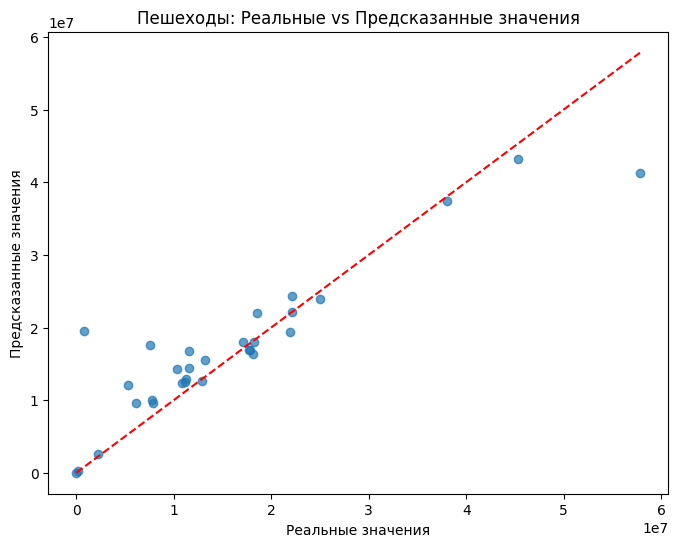

In [159]:
import matplotlib.pyplot as plt

# Визуализация предсказанных vs реальных значений для пешеходов
plt.figure(figsize=(8,6))
plt.scatter(y_test_walk, pred_walk, alpha=0.7)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Пешеходы: Реальные vs Предсказанные значения')
plt.plot([y_test_walk.min(), y_test_walk.max()], [y_test_walk.min(), y_test_walk.max()], 'r--')
plt.show()

Важность признаков для модели пешеходов:
                      Feature  Importance
10      road_count_pedestrian    0.447949
12              count_density    0.384429
0                  population    0.056964
5                      others    0.026272
11  road_length_pedestrian_km    0.017065
9                   area_sqkm    0.016790
4                  industrial    0.011811
3                  commercial    0.007603
1              building_count    0.006560
8                     unknown    0.006376
6                 residential    0.005694
7                     service    0.004702
2                avg_b_levels    0.004164
13           district_encoded    0.003622


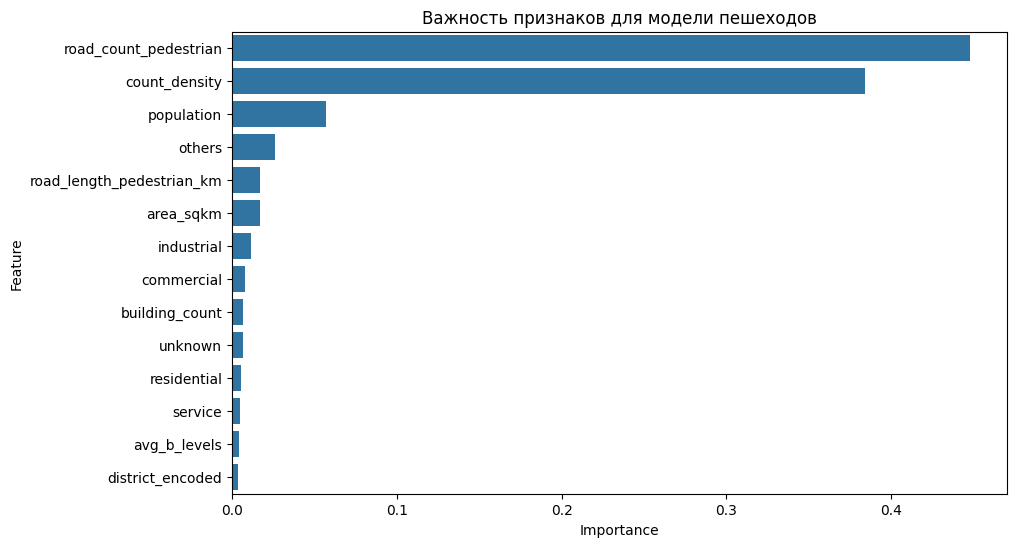

In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Важность признаков для модели пешеходов
importance_df_walk = pd.DataFrame({
    'Feature': features_walk.columns,
    'Importance': model_walk.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Важность признаков для модели пешеходов:")
print(importance_df_walk)

# Визуализация важности признаков для пешеходов
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df_walk)
plt.title('Важность признаков для модели пешеходов')
plt.show()

In [161]:
def predict_flow_with_new_building(district, increase_buildings=1, increase_population=100,
                                   increase_residential=1, increase_avg_b_levels=0.1,
                                   increase_area=0.1, increase_road_count_pedestrian=0, 
                                   increase_road_length_pedestrian_km=0.0):
    """
    Прогнозирует поток пешеходов с учётом добавления новых зданий и изменения инфраструктуры.
    
    Параметры:
    - district: название района
    - increase_buildings: количество новых зданий
    - increase_population: прирост населения
    - increase_residential: прирост количества жилых зданий
    - increase_avg_b_levels: прирост средней этажности
    - increase_area: прирост площади района (кв. км)
    - increase_road_count_pedestrian: прирост количества пешеходных дорог
    - increase_road_length_pedestrian_km: прирост длины пешеходных дорог (км)
    
    Возвращает:
    - DataFrame с предсказанными потоками до и после сценария
    """
    # Создаём копию данных
    scenario_features_walk = district_features.copy()
    
    # Увеличиваем показатели для выбранного района
    scenario_features_walk.loc[scenario_features_walk['district'] == district, 'building_count'] += increase_buildings
    scenario_features_walk.loc[scenario_features_walk['district'] == district, 'population'] += increase_population
    scenario_features_walk.loc[scenario_features_walk['district'] == district, 'residential'] += increase_residential
    scenario_features_walk.loc[scenario_features_walk['district'] == district, 'avg_b_levels'] += increase_avg_b_levels
    scenario_features_walk.loc[scenario_features_walk['district'] == district, 'area_sqkm'] += increase_area
    scenario_features_walk.loc[scenario_features_walk['district'] == district, 'road_count_pedestrian'] += increase_road_count_pedestrian
    scenario_features_walk.loc[scenario_features_walk['district'] == district, 'road_length_pedestrian_km'] += increase_road_length_pedestrian_km
    
    # Пересчитываем целевую переменную для сценария
    scenario_features_walk['pedestrian_flow_combined'] = (
        scenario_features_walk['road_count_pedestrian'] * scenario_features_walk['population']
    ) / scenario_features_walk['area_sqkm']
    
    # Обновляем признаки (убираем целевую переменную и 'district')
    scenario_features_walk_updated = scenario_features_walk.drop(columns=[
        'pedestrian_flow_combined', 
        'district', 
    ])
    
    # Добавляем закодированную переменную 'district_encoded'
    scenario_features_walk_updated = scenario_features_walk_updated[['population', 'building_count', 'avg_b_levels', 'commercial',
                                                                     'industrial', 'others', 'residential', 'service', 'unknown', 'area_sqkm', 
                                                                      'road_count_pedestrian', 'road_length_pedestrian_km', 'count_density', 'district_encoded']]
    
    # Масштабирование новых данных с использованием уже обученного масштабатора
    X_scenario_walk_scaled = scaler_walk.transform(scenario_features_walk_updated)
    
    # Предсказание новых потоков
    pred_scenario_walk_combined = model_walk.predict(X_scenario_walk_scaled)
    
    # Изменение потока
    # Оригинальный поток для района
    original_walk_combined = district_features.loc[district_features['district'] == district, 'pedestrian_flow_combined'].values[0]
    
    # Изменение
    delta_walk_combined = pred_scenario_walk_combined - original_walk_combined
    
    # Возвращаем результаты
    return pd.DataFrame({
        'district': [district],
        'original_walk_flow_combined': [original_walk_combined],
        'predicted_walk_flow_combined': [pred_scenario_walk_combined[0]],
        'delta_walk_flow_combined': [delta_walk_combined[0]]
    })


In [168]:
# Пример применения
district_to_modify = 'Арбат'  # Замените на реальный район

increase_buildings = 0
increase_population = 0
increase_residential = 0
increase_avg_b_levels = 0.0
increase_area = 0.0
increase_road_count_pedestrian = 0
increase_road_length_pedestrian_km = 0.0

scenario_result = predict_flow_with_new_building(
    district=district_to_modify,
    increase_buildings=increase_buildings,
    increase_population=increase_population,
    increase_residential=increase_residential,
    increase_avg_b_levels=increase_avg_b_levels,
    increase_area=increase_area,
    increase_road_count_pedestrian=increase_road_count_pedestrian,
    increase_road_length_pedestrian_km=increase_road_length_pedestrian_km,
)

scenario_result


,district,original_walk_flow_combined,predicted_walk_flow_combined,delta_walk_flow_combined
0,Арбат,1.749399e+07,2.288534e+07,5.391352e+06


In [130]:
combined_df.head()

,district,count_population,count_density
0,Академический,109200.0,18736.02
1,Алексеевский,80400.0,15196.79
2,Алтуфьевский,57300.0,17664.00
3,Арбат,35000.0,16838.39
4,Аэропорт,79100.0,17313.10
